<h1>PART A: Stock Price Forecasting</h1>


<h2>Importing Libraries</h2>

<hr>

In [123]:
# Import pandas and numpy
import numpy as np
import pandas as pd

# Import libraries to help us do the modeling
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product

# Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

# Scoring Metrics
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error



# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import warnings and ignore if warnings are shown
import warnings
warnings.filterwarnings('ignore')

In [124]:
import os
os.chdir('C:\\Users\\limso\\Downloads\\CA2\\datasets')

<h2>Load Dataset</h2>
<hr>

In [125]:
df = pd.read_csv('CA2-Stock-Price-Data.csv')

df.head()

,Date,Apple,Amazon,DBS
0,10/1/2018,56.814999,100.218002,25.969999
1,10/2/2018,57.320000,98.565498,25.629999
2,10/3/2018,58.017502,97.638000,25.950001
3,10/4/2018,56.997501,95.471001,25.760000
4,10/5/2018,56.072498,94.482498,25.770000


In [126]:
df['Date'] = pd.to_datetime(df['Date'],  format="%m/%d/%Y")
df.set_index("Date", inplace=True)
df.head()

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000


In [127]:
# Types of data in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-10-01 to 2023-09-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1257 non-null   float64
 1   Amazon  1257 non-null   float64
 2   DBS     1257 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


In [128]:
# Shape of the dataset
df.shape

(1257, 3)

In [129]:
# Getting the number of null values 
df.isnull().sum()

Apple     0
Amazon    0
DBS       0
dtype: int64

In [130]:
df.index

DatetimeIndex(['2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04',
               '2018-10-05', '2018-10-08', '2018-10-09', '2018-10-10',
               '2018-10-11', '2018-10-12',
               ...
               '2023-09-15', '2023-09-18', '2023-09-19', '2023-09-20',
               '2023-09-21', '2023-09-22', '2023-09-25', '2023-09-26',
               '2023-09-27', '2023-09-28'],
              dtype='datetime64[ns]', name='Date', length=1257, freq=None)

In [131]:
df.reset_index(inplace=True)

expected_dates = pd.date_range(start='2018-10-01', end='2023-09-28', freq='D')

missing_dates = expected_dates[~expected_dates.isin(df.Date)]

missing_df = pd.DataFrame({'Date': missing_dates})

df = pd.concat([df, missing_df]).sort_values('Date').reset_index(drop=True)

df.set_index("Date", inplace=True)


In [132]:
df.head()

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000


<b><u>Observation</u></b>


The shape of the dataset: (1257, 3)
<br>
Datatypes of all features are numerical
<br>
There appears to be missing dates in the dataset


<Axes: ylabel='Date'>

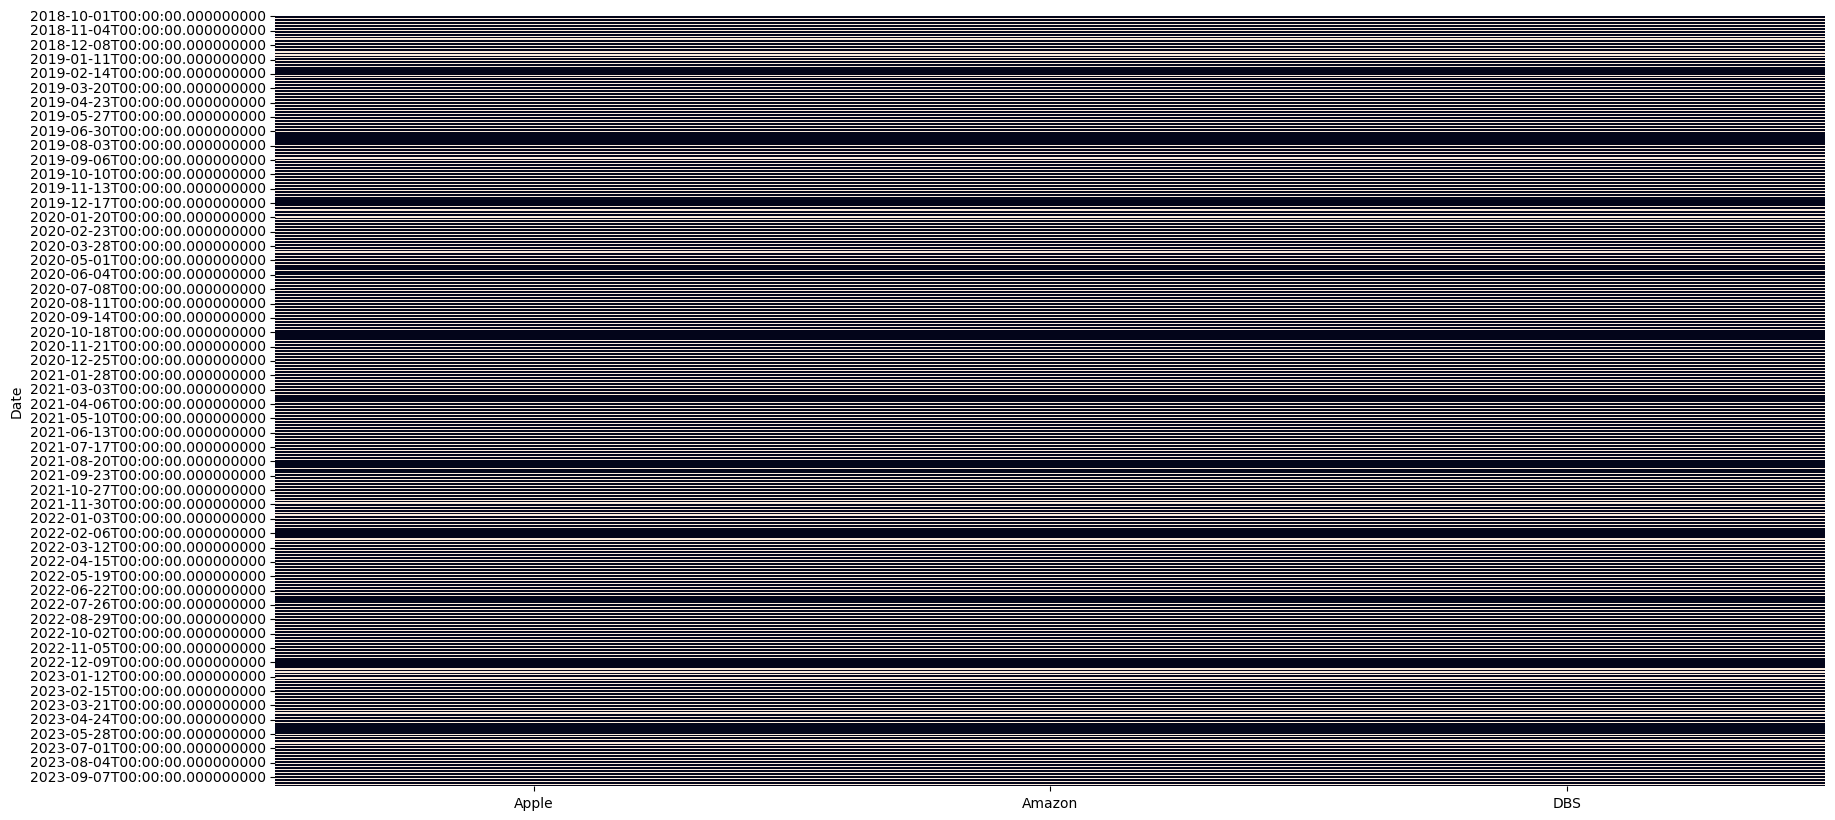

In [133]:
# Heatmap to show missing data in the dataset
sns.heatmap(df.isnull(), cbar=False)

In [134]:
df = df.fillna(method='ffill')

<Axes: ylabel='Date'>

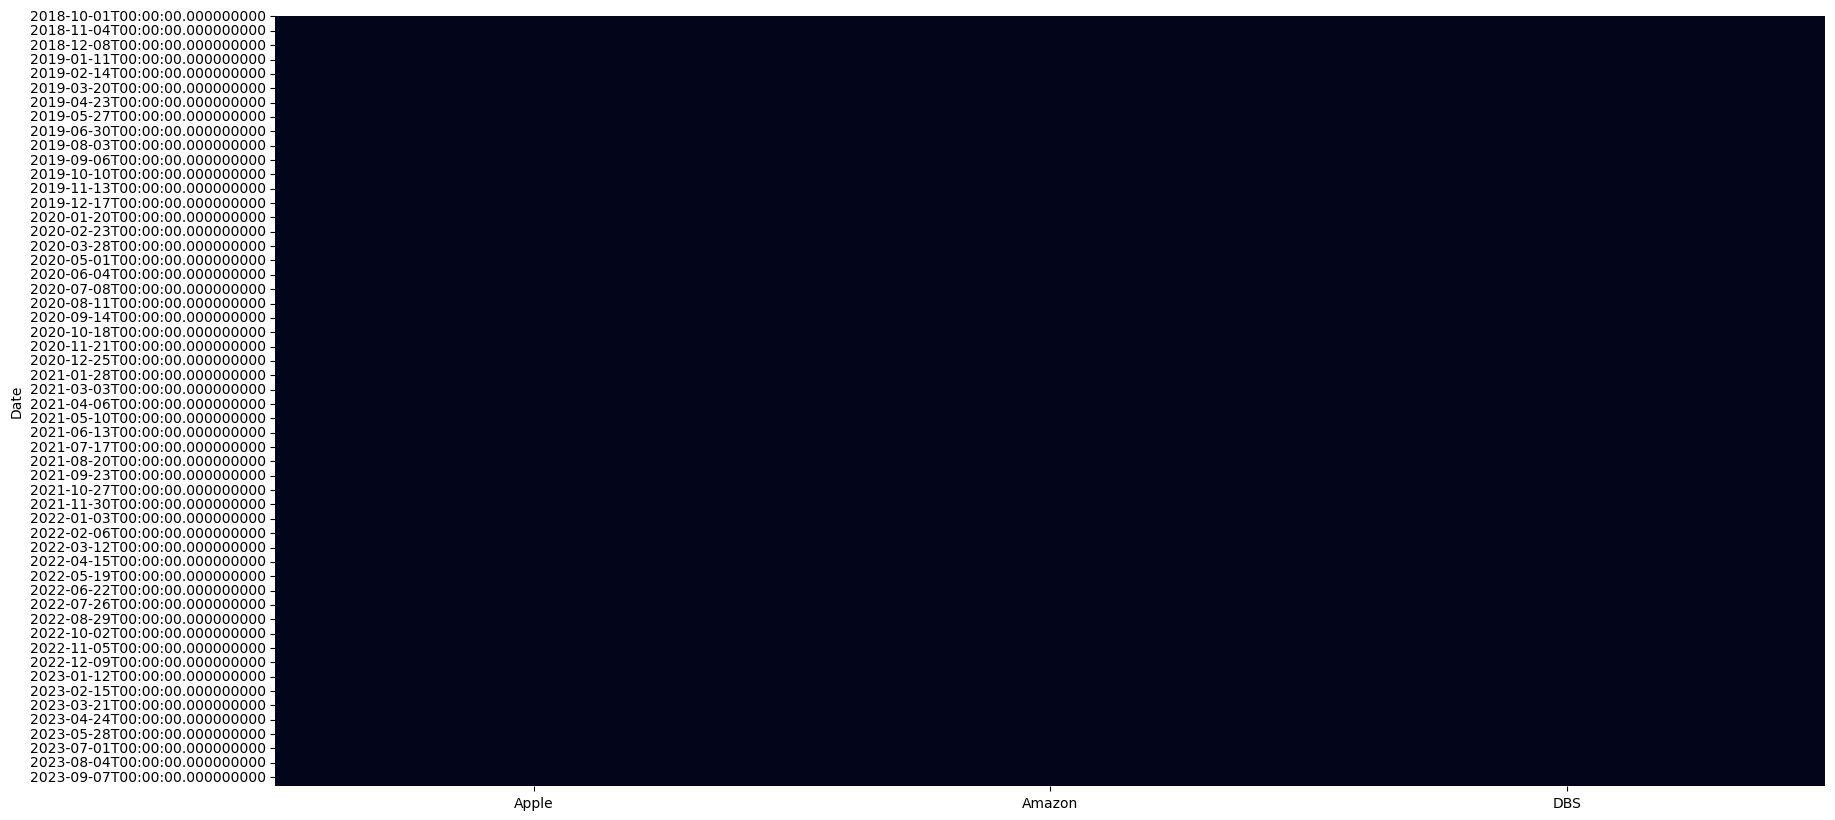

In [135]:
sns.heatmap(df.isnull(), cbar=False)

### Visualisation of Time Series

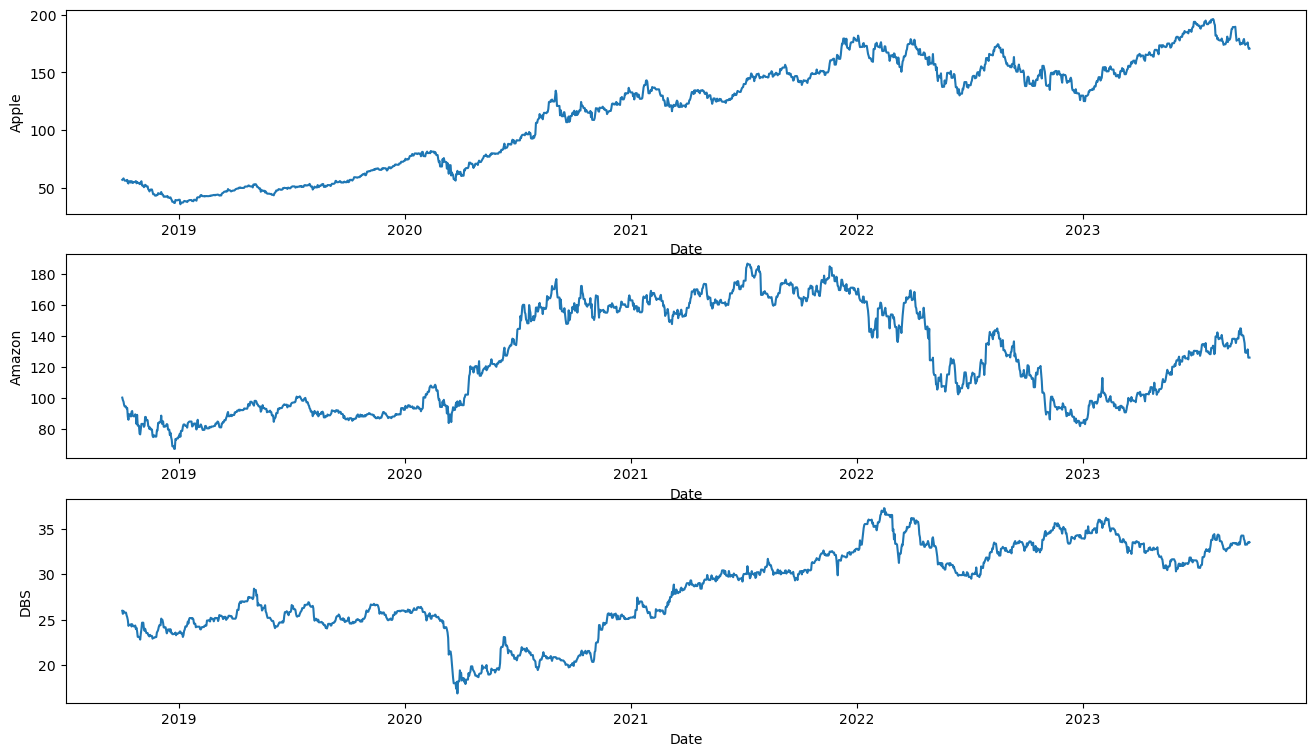

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,9))

sns.lineplot(df['Apple'], ax=ax1)
sns.lineplot(df['Amazon'], ax=ax2)
sns.lineplot(df['DBS'], ax=ax3)

plt.show()

<h2>Univariate Analysis</h2>
<hr>

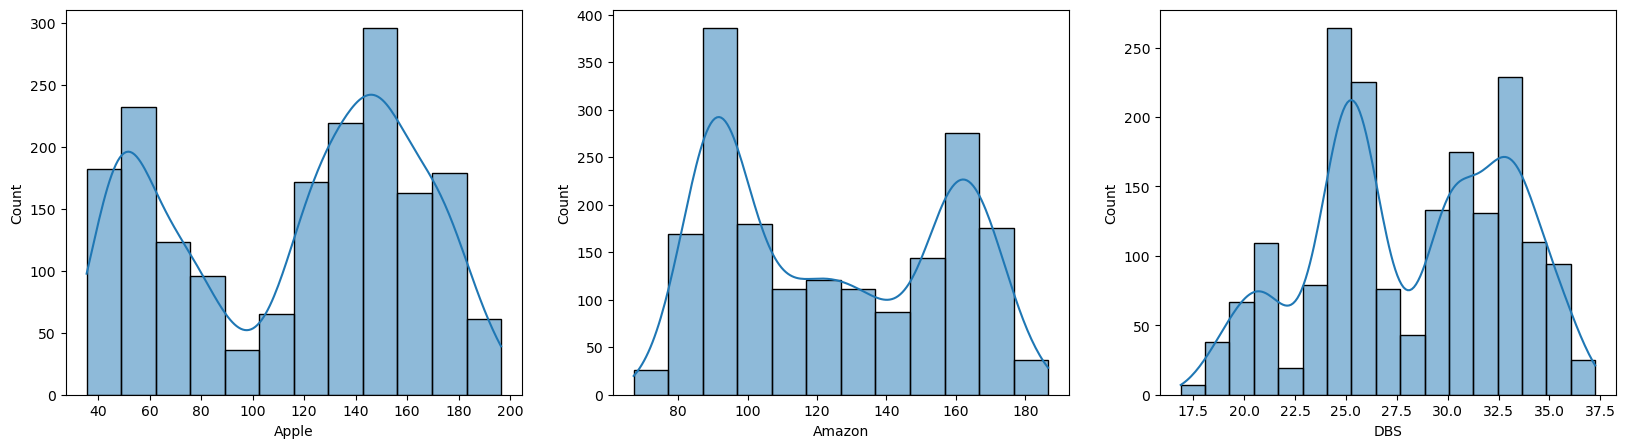

In [137]:
# Histplot 
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data=df, x='Apple', ax=ax[0], kde=True)
sns.histplot(data=df, x='Amazon', ax=ax[1], kde=True)
sns.histplot(data=df, x='DBS', ax=ax[2], kde=True)


plt.show()

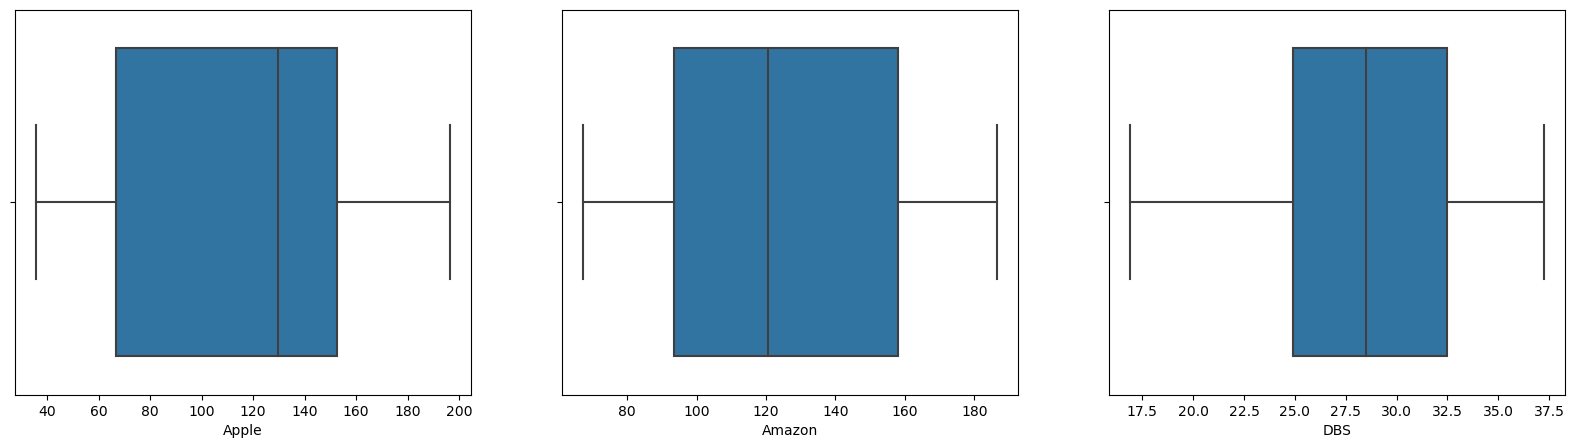

In [138]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(data=df, x='Apple', ax=ax[0])
sns.boxplot(data=df, x='Amazon',ax=ax[1])
sns.boxplot(data=df, x='DBS',ax=ax[2])

plt.show()

Apple
<ul>
<li>Apple have a median of 130</li>
<li>There are no outliers</li>
</ul>

Amazon
<ul>
<li>Amazon have a median of 120</li>
<li>There are no outliers</li>
</ul>

DBS
<ul>
<li>DBS have a median of around 28.5</li>
<li>There are no outliers</li>
</ul>

<h2>Time Series Decomposition</h2>
<hr>

Seasonal Decomposition
Column: Apple


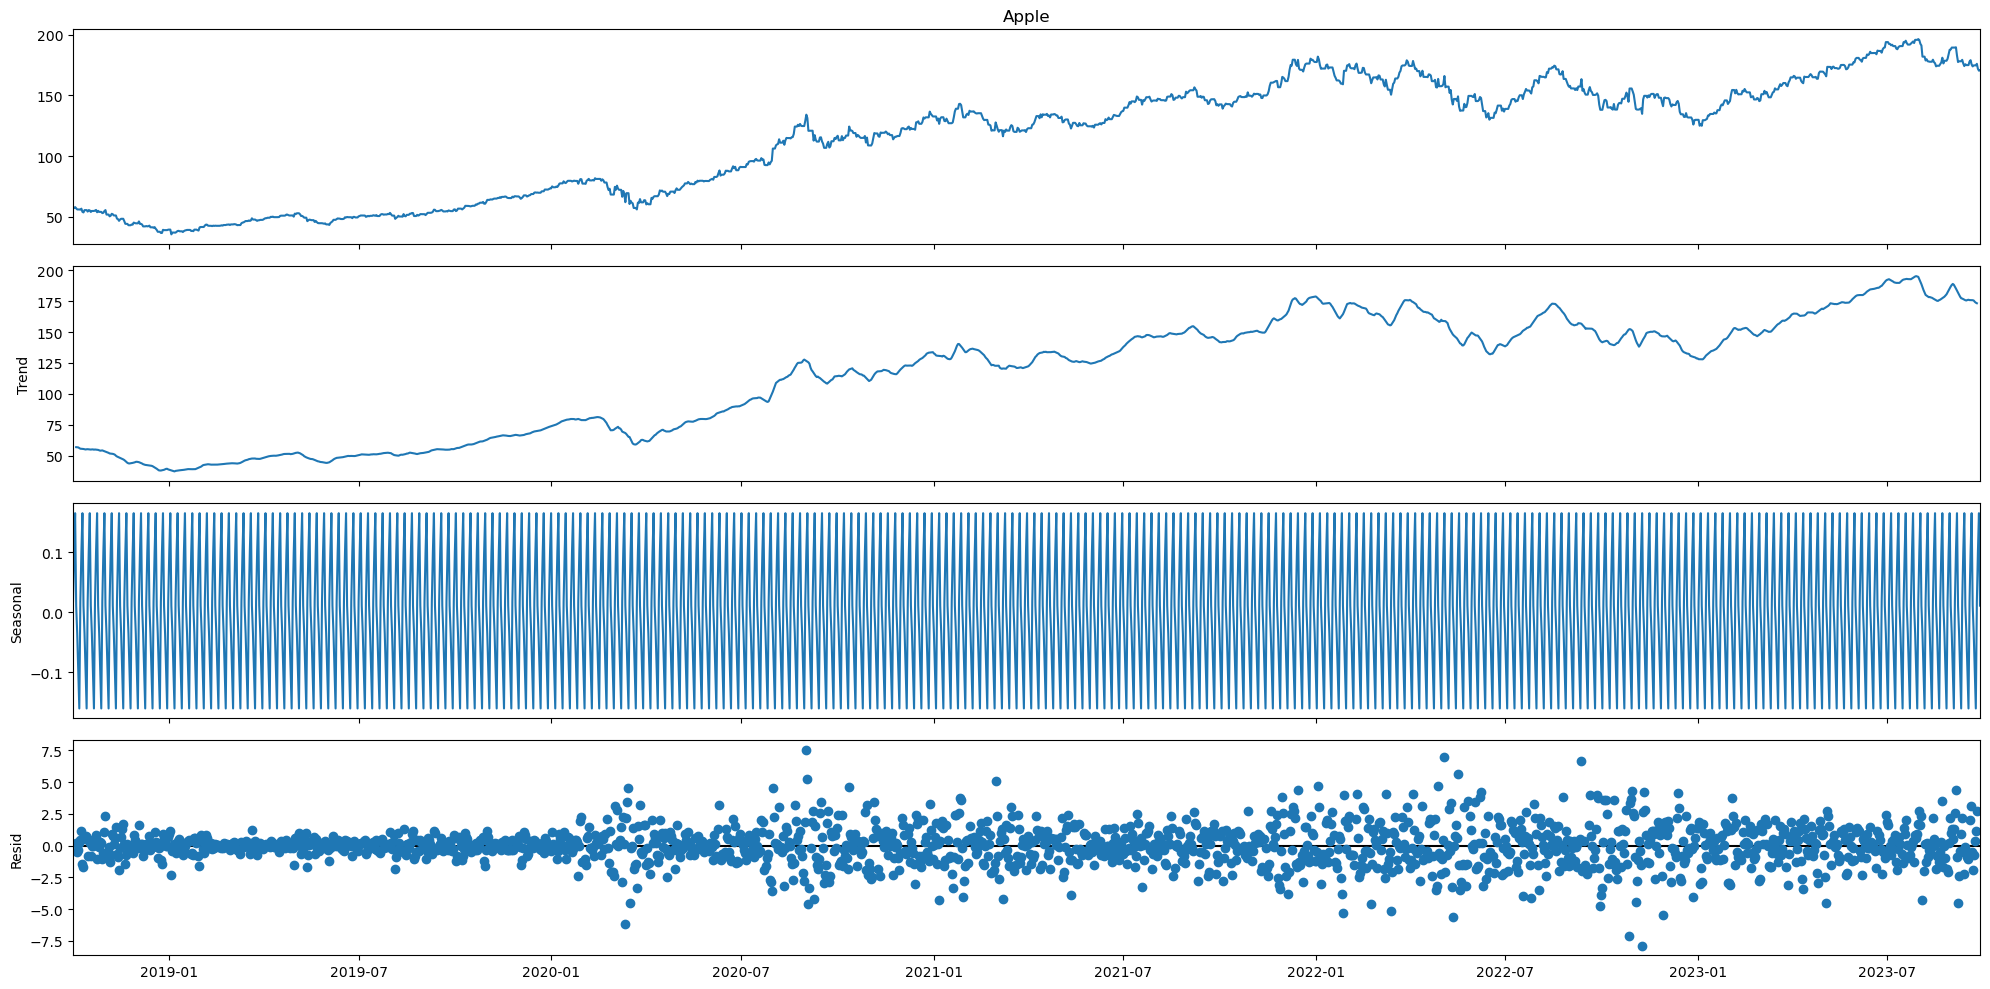

Seasonal Decomposition
Column: Amazon


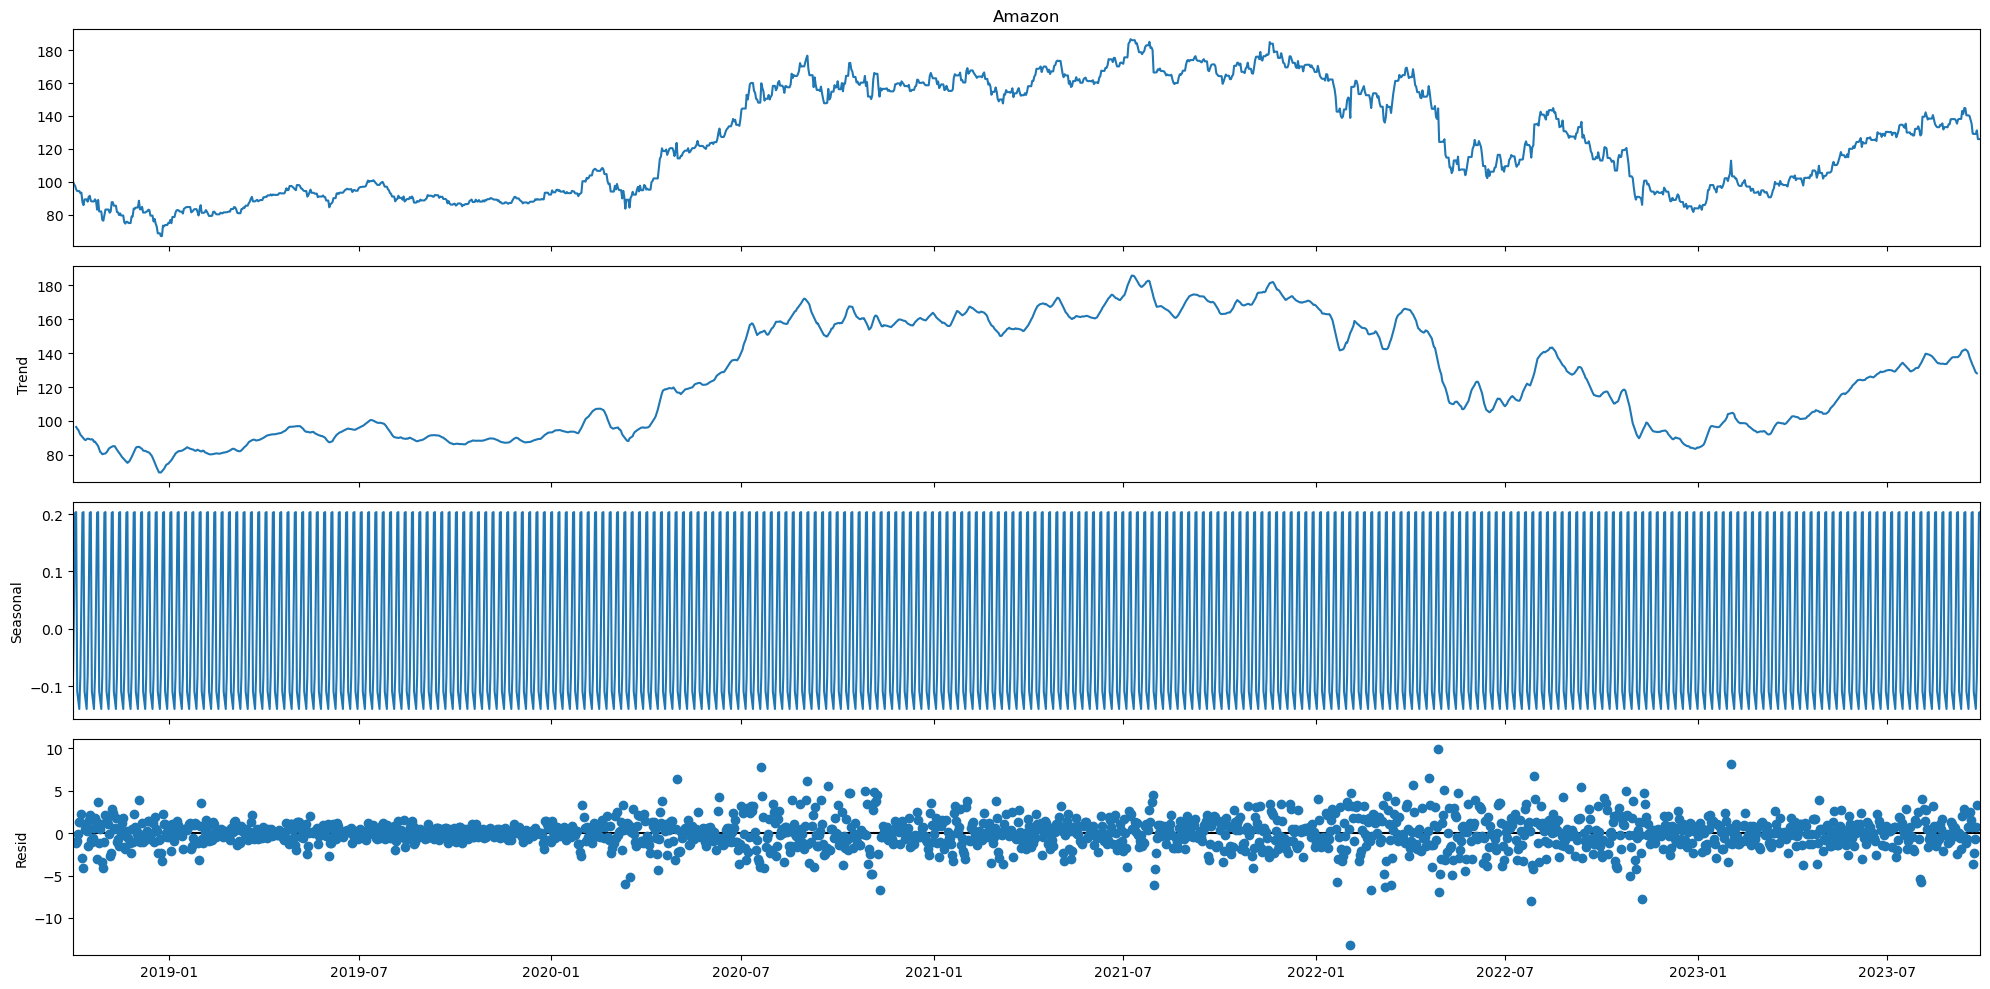

Seasonal Decomposition
Column: DBS


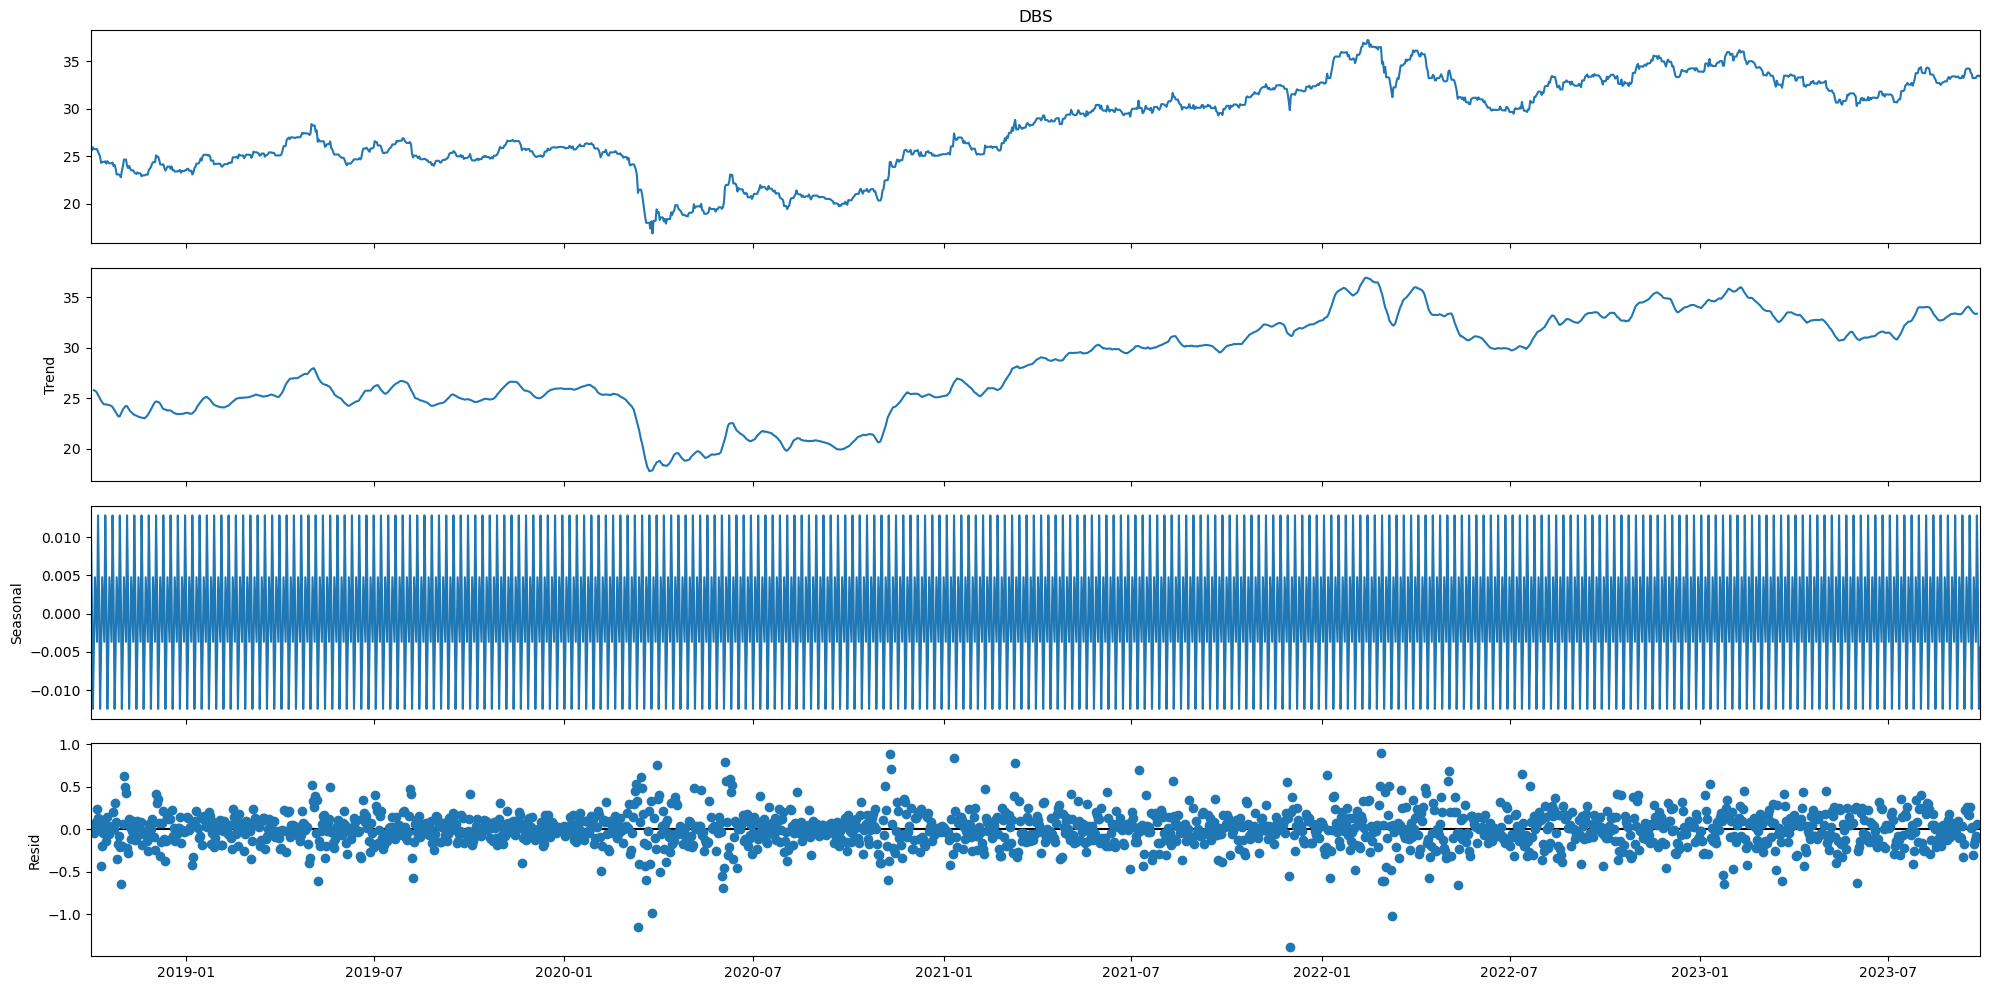

In [139]:
for i in df.columns:
    plt.rc("figure", figsize=(20, 10))
    print("Seasonal Decomposition\nColumn:", i)
    decomposition = seasonal_decompose(df[i])
    decomposition.plot()
    plt.show()

## ADF Test for Stationarity

We need to ensure the time-series is stationary.

To verify stationarity, we will be using ADF Test at Significant Value p = 0.05, with the null hypothesis that the time-series is non-stationary.

In [140]:
appleADF = df['Apple']

amazonADF = df['Amazon']

dbsADF = df['DBS']

### Apple

In [141]:
# Apple

appleADF_result = adfuller(appleADF)
print(f'ADF Statistic: {appleADF_result[0]}')
print(f'p-value: {appleADF_result[1]}')

ADF Statistic: -0.9838100771942361
p-value: 0.7591233096947595


* H0 : the series is non-stationary
* H1 : the series is stationary

   the p-value is extremely high (p>0.05) => non-stationary.

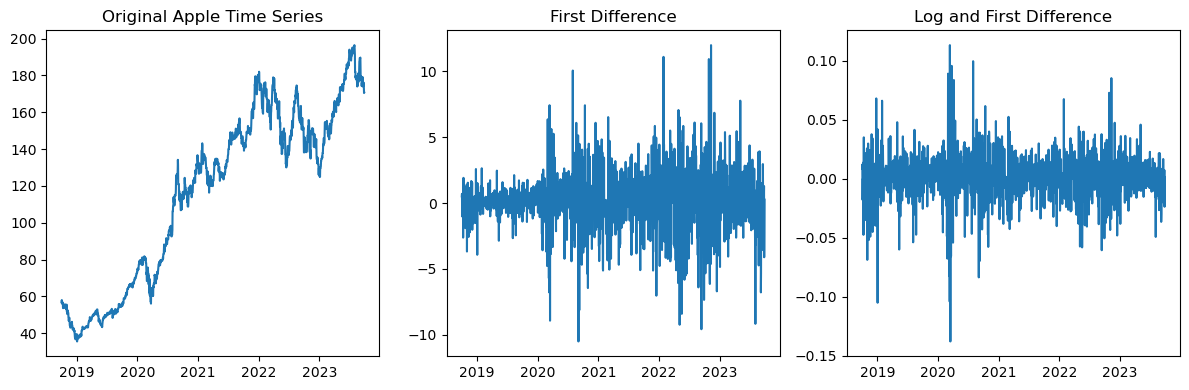

In [142]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(appleADF)
plt.title('Original Apple Time Series')

plt.subplot(1, 3, 2)
plt.plot(appleADF.diff())
plt.title('First Difference')

plt.subplot(1, 3, 3)
plt.plot(np.log(appleADF).diff())
plt.title('Log and First Difference')

plt.tight_layout()
plt.show()

* The original series is not stationary
* After applying first-order differencing, it is still not quite stationary (some variance)
* After applying log transformation followed by first-order differencing, the series now appears stationary.

In [143]:
appleADF = np.log(appleADF).diff()
appleADF.dropna(inplace = True)

appleADF_result = adfuller(appleADF)
print(f'ADF Statistic: {appleADF_result[0]}')
print(f'p-value: {appleADF_result[1]}')

ADF Statistic: -8.600725224677648
p-value: 6.880735259649377e-14


the p-value is extremely low (p<0.05) => stationary.

### Amazon

In [144]:
# Amazon

amazonADF_result = adfuller(amazonADF)
print(f'ADF Statistic: {amazonADF_result[0]}')
print(f'p-value: {amazonADF_result[1]}')

ADF Statistic: -1.575605610379156
p-value: 0.4958349516623555


* H0 : the series is non-stationary
* H1 : the series is stationary

   the p-value is extremely high (p>0.05) => non-stationary.

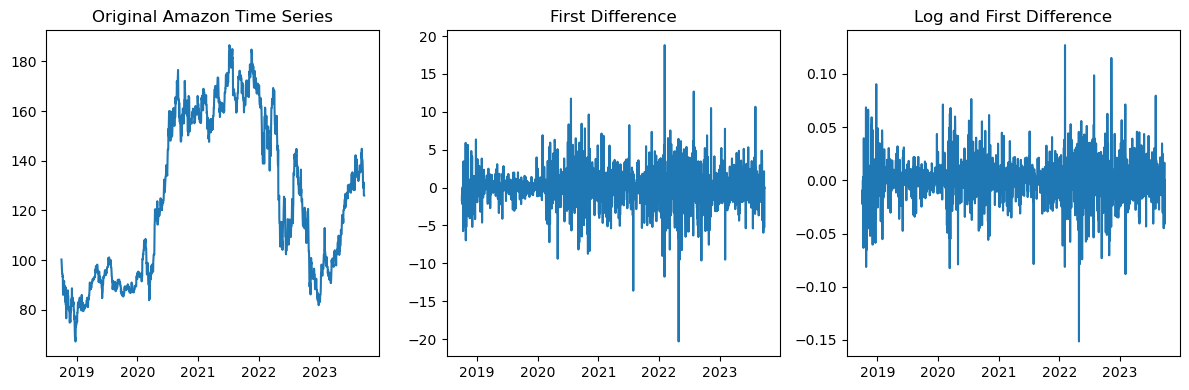

In [145]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(amazonADF)
plt.title('Original Amazon Time Series')

plt.subplot(1, 3, 2)
plt.plot(amazonADF.diff())
plt.title('First Difference')

plt.subplot(1, 3, 3)
plt.plot(np.log(amazonADF).diff())
plt.title('Log and First Difference')

plt.tight_layout()
plt.show()

* The original series is not stationary
* After applying first-order differencing, it is stationary
* After applying log transformation followed by first-order differencing, the series is stationary.

In [146]:
# Amazon
amazonADF = np.log(amazonADF).diff()
amazonADF.dropna(inplace = True)

amazonADF_result = adfuller(amazonADF)
print(f'ADF Statistic: {amazonADF_result[0]}')
print(f'p-value: {amazonADF_result[1]}')

ADF Statistic: -45.544593824154525
p-value: 0.0


the p-value is 0 (p<0.05) => stationary.

### DBS

In [147]:
# DBS

dbsADF_result = adfuller(dbsADF)                                                                                                             
print(f'ADF Statistic: {dbsADF_result[0]}')
print(f'p-value: {dbsADF_result[1]}')

ADF Statistic: -1.2675427384561586
p-value: 0.6438876920102607


* H0 : the series is non-stationary
* H1 : the series is stationary

   the p-value is extremely high (p>0.05) => non-stationary.

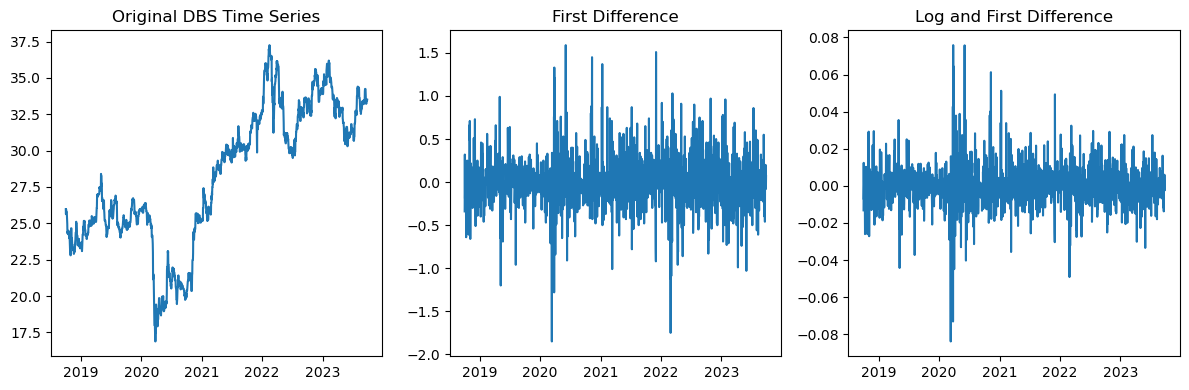

In [148]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(dbsADF)
plt.title('Original DBS Time Series')

plt.subplot(1, 3, 2)
plt.plot(dbsADF.diff())
plt.title('First Difference')

plt.subplot(1, 3, 3)
plt.plot(np.log(dbsADF).diff())
plt.title('Log and First Difference')

plt.tight_layout()
plt.show()

* The original series is not stationary
* After applying first-order differencing, it is stationary
* After applying log transformation followed by first-order differencing, the series is stationary.

In [149]:
dbsADF = np.log(dbsADF).diff()
dbsADF.dropna(inplace = True)

dbsADF_result = adfuller(dbsADF)
print(f'ADF Statistic: {amazonADF_result[0]}')
print(f'p-value: {amazonADF_result[1]}')

ADF Statistic: -45.544593824154525
p-value: 0.0


the p-value is 0 (p<0.05) => stationary.

## Autocorrelation Analysis

### Ljung-Box Test for Autocorrelation

### Apple

In [150]:
lb_test_result = acorr_ljungbox(appleADF, lags=[20], return_df=True)
lbtest_pvalue = lb_test_result['lb_pvalue']
print(f"p-value of Ljung-Box Test: {lbtest_pvalue}")

p-value of Ljung-Box Test: 20    1.859867e-14
Name: lb_pvalue, dtype: float64


* H0 : Autocorrelation is zero
* H1 : Autocorrelation is not zero

Reject H0 given that p-value (<=0.05) => autocorrelations detected! => not white-noise

### Amazon

In [151]:
lb_test_result = acorr_ljungbox(amazonADF, lags=[20], return_df=True)
lbtest_pvalue = lb_test_result['lb_pvalue']
print(f"p-value of Ljung-Box Test: {lbtest_pvalue}")

p-value of Ljung-Box Test: 20    0.002444
Name: lb_pvalue, dtype: float64


* H0 : Autocorrelation is zero
* H1 : Autocorrelation is not zero

Reject H0 given that p-value (<=0.05) => autocorrelations detected! => not white-noise

### DBS

In [152]:
lb_test_result = acorr_ljungbox(dbsADF, lags=[20], return_df=True)
lbtest_pvalue = lb_test_result['lb_pvalue']
print(f"p-value of Ljung-Box Test: {lbtest_pvalue}")

p-value of Ljung-Box Test: 20    0.000004
Name: lb_pvalue, dtype: float64


* H0 : Autocorrelation is zero
* H1 : Autocorrelation is not zero

Reject H0 given that p-value (<=0.05) => autocorrelations detected! => not white-noise

### ACF Test for Autocorrelation

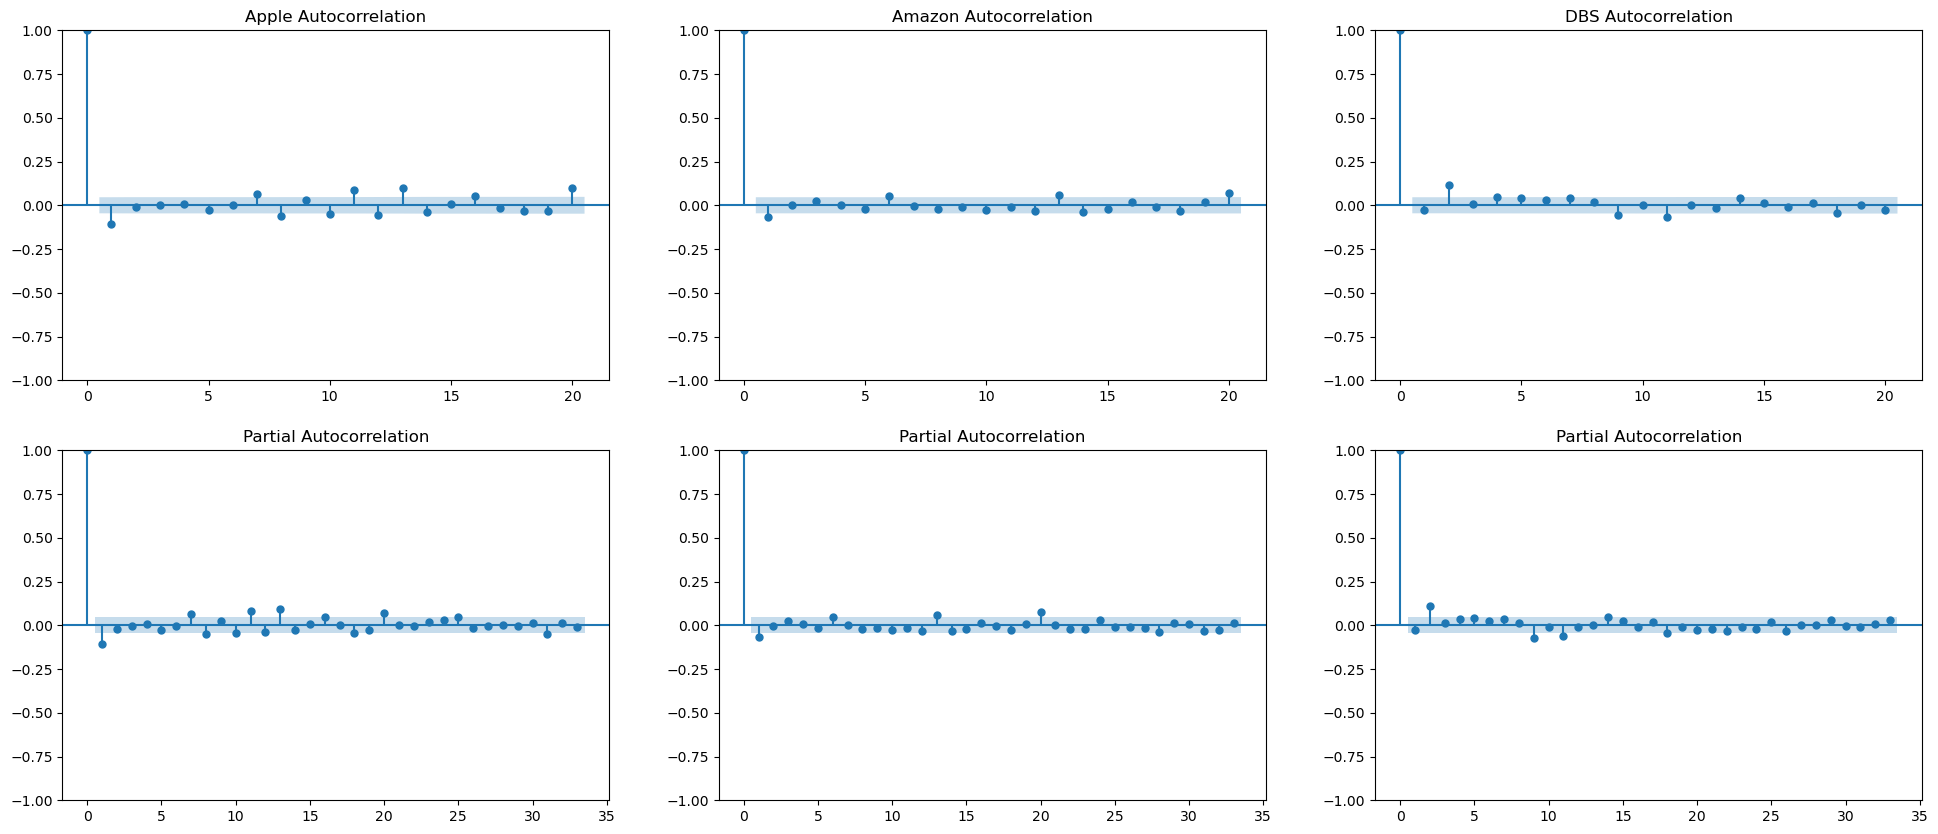

In [153]:
# Autocorrelation 
fig, ((ax1, ax2 , ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize = (24,10))

plot_acf(appleADF, ax=ax1, lags=20)
plot_acf(amazonADF, ax=ax2, lags=20)
plot_acf(dbsADF, ax=ax3, lags=20)
plot_pacf(appleADF, ax=ax4)
plot_pacf(amazonADF, ax=ax5)
plot_pacf(dbsADF, ax=ax6)
ax1.set_title("Apple Autocorrelation")
ax2.set_title("Amazon Autocorrelation")
ax3.set_title("DBS Autocorrelation")

plt.show()

We note that there are some significant spikes in quite a few lags. This is indicative of autocorrelations, again underscoring that the time series is not white noise.<br>
We conclude that all of these are not white noise time series

<h2>Tuning of the hyperparameters of models</h2>
<hr>

In [154]:
exog = pd.concat([appleADF, amazonADF, dbsADF], axis=1)

exog

,Apple,Amazon,DBS
Date,,,
2018-10-02,0.008849,-0.016627,-0.013178
2018-10-03,0.012095,-0.009455,0.012408
2018-10-04,-0.017737,-0.022444,-0.007349
2018-10-05,-0.016362,-0.010408,0.000388
2018-10-06,0.000000,0.000000,0.000000
...,...,...,...
2023-09-24,0.000000,0.000000,0.000000
2023-09-25,0.007353,0.016514,0.005997
2023-09-26,-0.023677,-0.041133,0.001792


### Model Selection

### SARIMAX
<hr>

In [155]:
def manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, training_data, exog):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    all_combinations = list(product(p_values, d_values, q_values, P_values, D_values, Q_values))

    for idx, (p, d, q, P, D, Q) in enumerate(all_combinations, start=1):
        order = (p, d, q)
        seasonal_order = (P, D, Q, s_values[0])  

        # Fit SARIMAX model
        model = SARIMAX(training_data, order=order, seasonal_order=seasonal_order, exog=exog)
        results = model.fit(disp=False)
        aic = results.aic

        # Update best values if a model with lower AIC is found
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_seasonal_order = seasonal_order
        
        # Provide progress update
        print(f"Completed {idx}/{len(all_combinations)}: Order {order}, Seasonal Order {seasonal_order}")

    return {"best_aic": best_aic, "best_order": best_order, "best_seasonal_order": best_seasonal_order}




### Apple 

#### Apple with Amazon




In [156]:
traindata_apple = appleADF.iloc[:len(appleADF)-60]
testdata_apple = appleADF.iloc[len(appleADF)-60:]

In [157]:
p_values = range(0,2)
d_values = range(0,1)
q_values = range(0,2)
P_values = range(1,3)
D_values = [1]
Q_values = range(2)
s_values = [12] 

apple_w_amazon = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_apple, exog[['Amazon']][:len(appleADF)-60])

print(f"Best AIC: {apple_w_amazon['best_aic']}")
print(f"Best (p, d, q) order: {apple_w_amazon['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {apple_w_amazon['best_seasonal_order']}")

Completed 1/16: Order (0, 0, 0), Seasonal Order (1, 1, 0, 12)
Completed 2/16: Order (0, 0, 0), Seasonal Order (1, 1, 1, 12)
Completed 3/16: Order (0, 0, 0), Seasonal Order (2, 1, 0, 12)
Completed 4/16: Order (0, 0, 0), Seasonal Order (2, 1, 1, 12)
Completed 5/16: Order (0, 0, 1), Seasonal Order (1, 1, 0, 12)
Completed 6/16: Order (0, 0, 1), Seasonal Order (1, 1, 1, 12)
Completed 7/16: Order (0, 0, 1), Seasonal Order (2, 1, 0, 12)
Completed 8/16: Order (0, 0, 1), Seasonal Order (2, 1, 1, 12)
Completed 9/16: Order (1, 0, 0), Seasonal Order (1, 1, 0, 12)
Completed 10/16: Order (1, 0, 0), Seasonal Order (1, 1, 1, 12)
Completed 11/16: Order (1, 0, 0), Seasonal Order (2, 1, 0, 12)
Completed 12/16: Order (1, 0, 0), Seasonal Order (2, 1, 1, 12)
Completed 13/16: Order (1, 0, 1), Seasonal Order (1, 1, 0, 12)
Completed 14/16: Order (1, 0, 1), Seasonal Order (1, 1, 1, 12)
Completed 15/16: Order (1, 0, 1), Seasonal Order (2, 1, 0, 12)
Completed 16/16: Order (1, 0, 1), Seasonal Order (2, 1, 1, 12)
B

In [158]:
apple_w_amazon_model = SARIMAX(traindata_apple, order=apple_w_amazon['best_order'], seasonal_order=apple_w_amazon['best_seasonal_order'], exog=exog[['Amazon']][:len(appleADF)-60])
apple_w_amazon_result = apple_w_amazon_model.fit()

print(apple_w_amazon_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Apple   No. Observations:                 1763
Model:             SARIMAX(0, 0, 1)x(2, 1, 1, 12)   Log Likelihood                5057.306
Date:                            Mon, 12 Feb 2024   AIC                         -10102.613
Time:                                    17:25:17   BIC                         -10069.805
Sample:                                10-02-2018   HQIC                        -10090.485
                                     - 07-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Amazon         0.5938      0.008     77.970      0.000       0.579       0.609
ma.L1         -0.0567      0.020   

In [159]:
# Checking the residuals of the fitted model
residuals = apple_w_amazon_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])


ADF Statistic (residuals): -41.932659
p-value (residuals): 0.000000


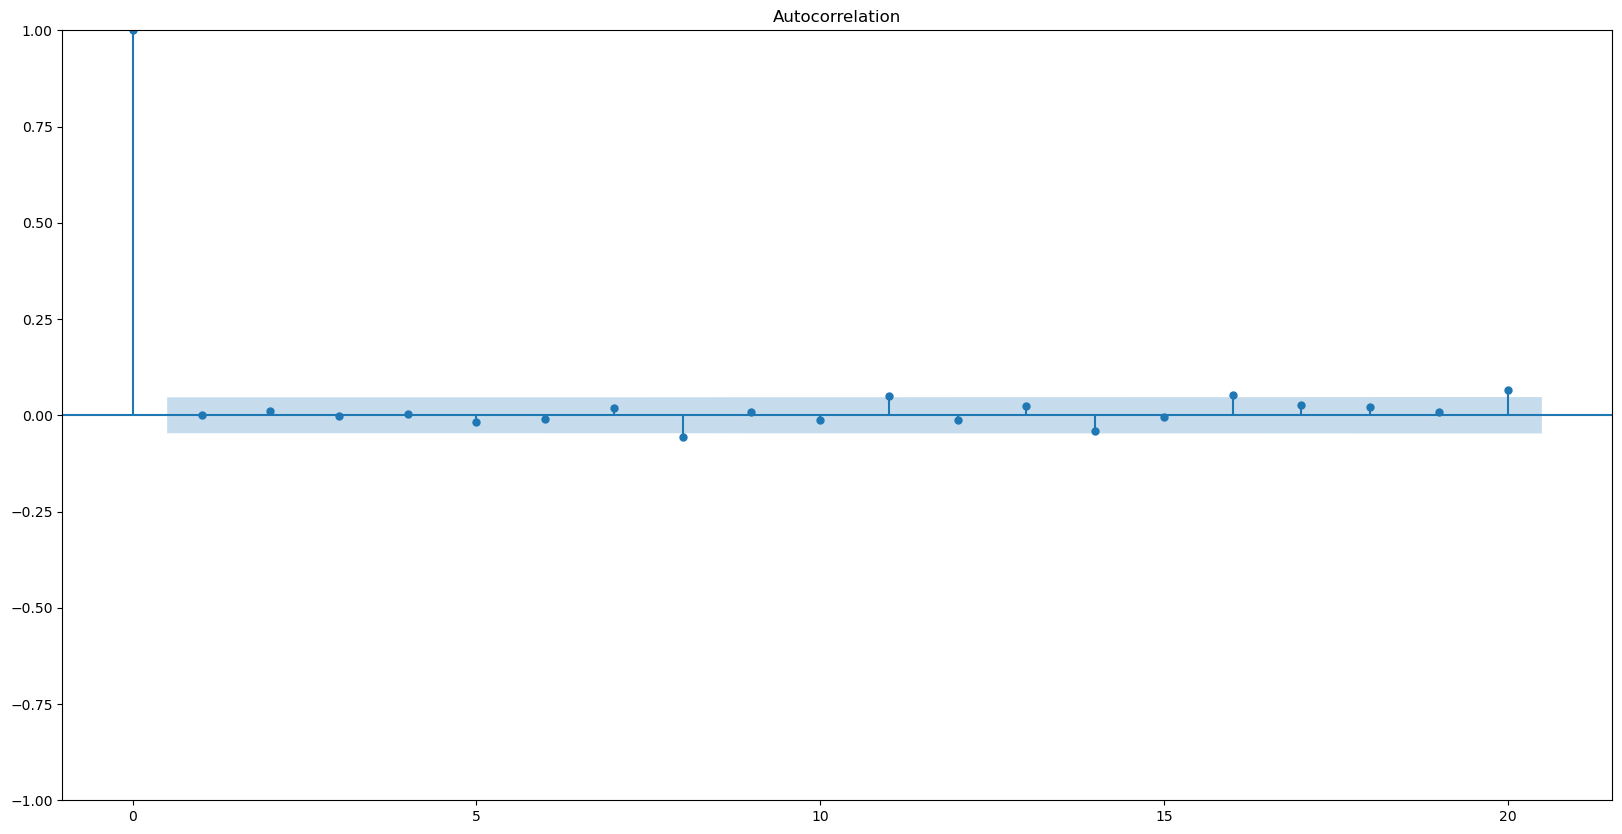

In [160]:
plot_acf(residuals, lags=20)
plt.show()

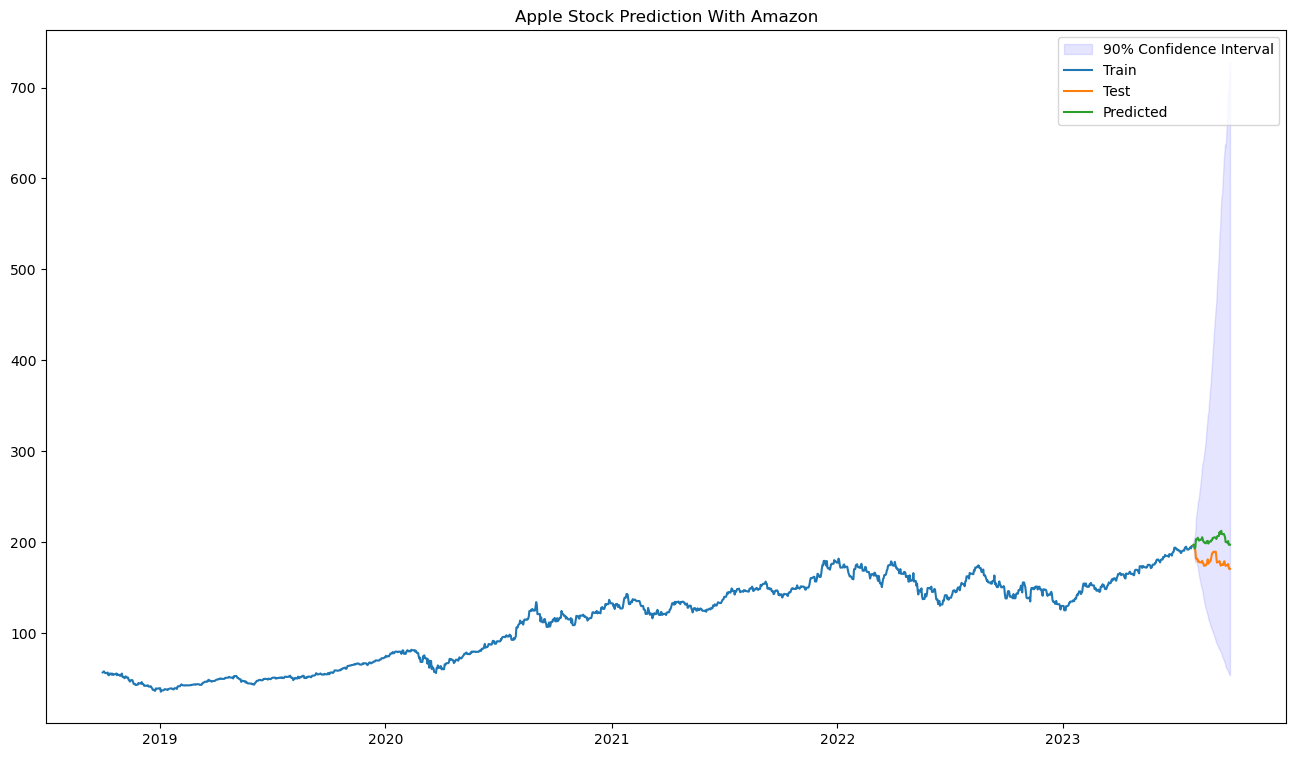

In [161]:
traindata_apple_unmodified = df['Apple'].iloc[:len(df['DBS'])-60]
testdata_apple_unmodified = df['Apple'].iloc[len(df['DBS'])-60:]

# Make predictions
pred = apple_w_amazon_result.predict(start=len(traindata_apple_unmodified)-1, 
                                            end=len(traindata_apple_unmodified)+58, exog=exog[['Amazon']][len(appleADF)-60:])

forecast = apple_w_amazon_result.get_prediction(start=len(traindata_apple_unmodified)-1, 
                                            end=len(traindata_apple_unmodified)+58, exog=exog[['Amazon']][len(appleADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_apple_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

apple_w_amazon['mse'] = mean_squared_error(testdata_apple_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_apple_unmodified.index, traindata_apple_unmodified, label='Train')
plt.plot(testdata_apple_unmodified.index, testdata_apple_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')


plt.legend()
plt.title('Apple Stock Prediction With Amazon')
plt.show()


#### Apple with DBS

In [162]:
apple_w_dbs = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_apple, exog[['DBS']][:len(appleADF)-60])

print(f"Best AIC: {apple_w_dbs['best_aic']}")
print(f"Best (p, d, q) order: {apple_w_dbs['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {apple_w_dbs['best_seasonal_order']}")

Completed 1/16: Order (0, 0, 0), Seasonal Order (1, 1, 0, 12)
Completed 2/16: Order (0, 0, 0), Seasonal Order (1, 1, 1, 12)
Completed 3/16: Order (0, 0, 0), Seasonal Order (2, 1, 0, 12)
Completed 4/16: Order (0, 0, 0), Seasonal Order (2, 1, 1, 12)
Completed 5/16: Order (0, 0, 1), Seasonal Order (1, 1, 0, 12)
Completed 6/16: Order (0, 0, 1), Seasonal Order (1, 1, 1, 12)
Completed 7/16: Order (0, 0, 1), Seasonal Order (2, 1, 0, 12)
Completed 8/16: Order (0, 0, 1), Seasonal Order (2, 1, 1, 12)
Completed 9/16: Order (1, 0, 0), Seasonal Order (1, 1, 0, 12)
Completed 10/16: Order (1, 0, 0), Seasonal Order (1, 1, 1, 12)
Completed 11/16: Order (1, 0, 0), Seasonal Order (2, 1, 0, 12)
Completed 12/16: Order (1, 0, 0), Seasonal Order (2, 1, 1, 12)
Completed 13/16: Order (1, 0, 1), Seasonal Order (1, 1, 0, 12)
Completed 14/16: Order (1, 0, 1), Seasonal Order (1, 1, 1, 12)
Completed 15/16: Order (1, 0, 1), Seasonal Order (2, 1, 0, 12)
Completed 16/16: Order (1, 0, 1), Seasonal Order (2, 1, 1, 12)
B

In [163]:
apple_w_dbs_model = SARIMAX(traindata_apple, order=apple_w_dbs['best_order'], seasonal_order=apple_w_dbs['best_seasonal_order'], exog=exog[['DBS']][:len(appleADF)-60])
apple_w_dbs_result = apple_w_dbs_model.fit()

print(apple_w_dbs_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Apple   No. Observations:                 1763
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood                4582.386
Date:                              Mon, 12 Feb 2024   AIC                          -9152.772
Time:                                      17:26:53   BIC                          -9119.965
Sample:                                  10-02-2018   HQIC                         -9140.645
                                       - 07-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DBS            0.0954      0.022      4.361      0.000       0.053       0.138
ar.L1         -0.11

In [164]:
# Checking the residuals of the fitted model
residuals = apple_w_dbs_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -8.099307
p-value (residuals): 0.000000


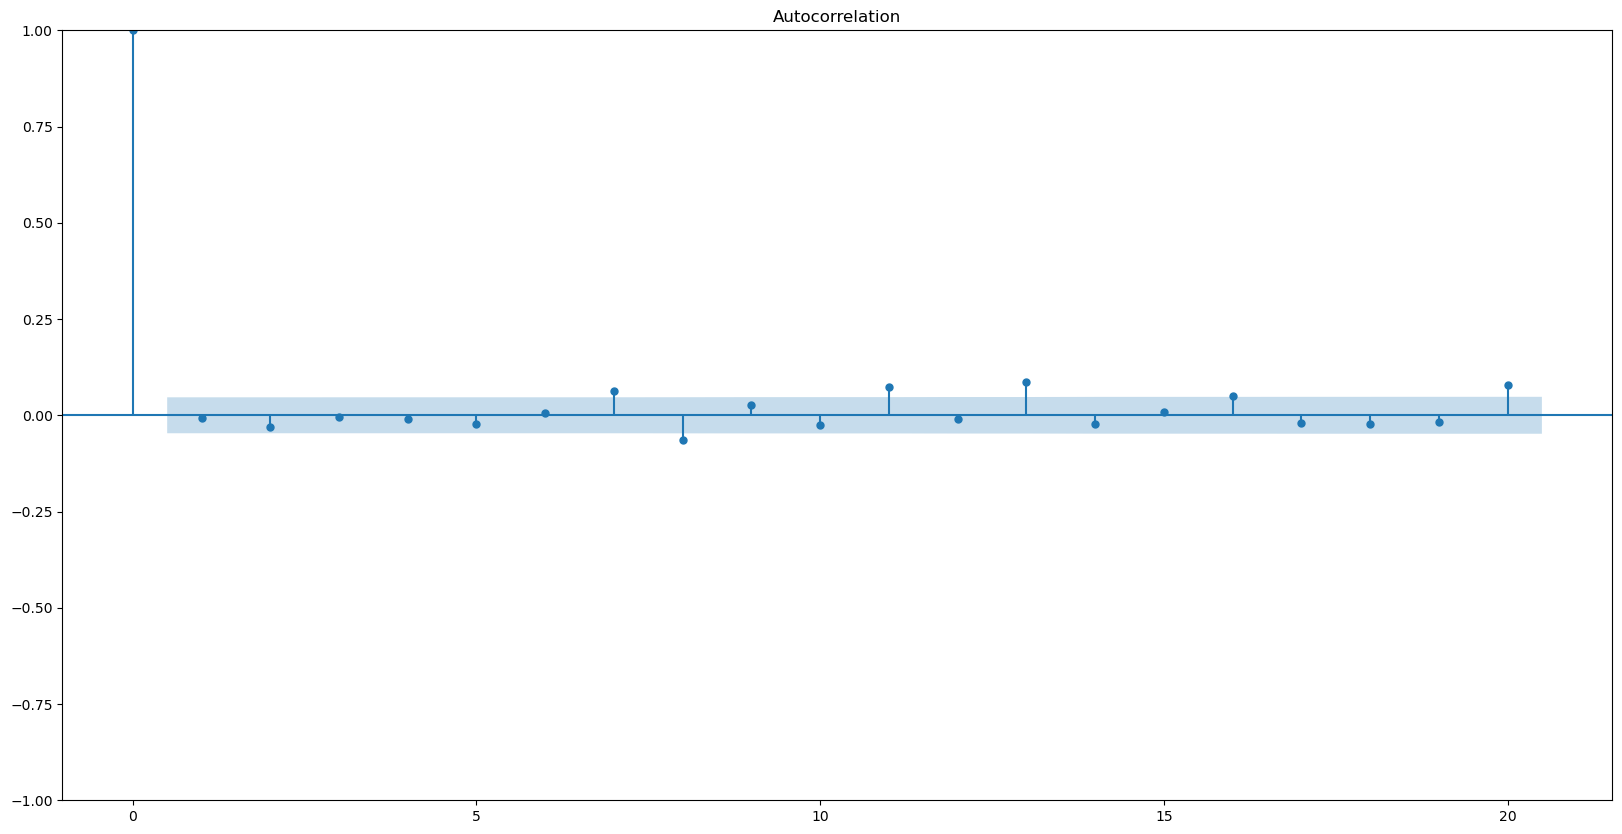

In [165]:
plot_acf(residuals, lags=20)
plt.show()

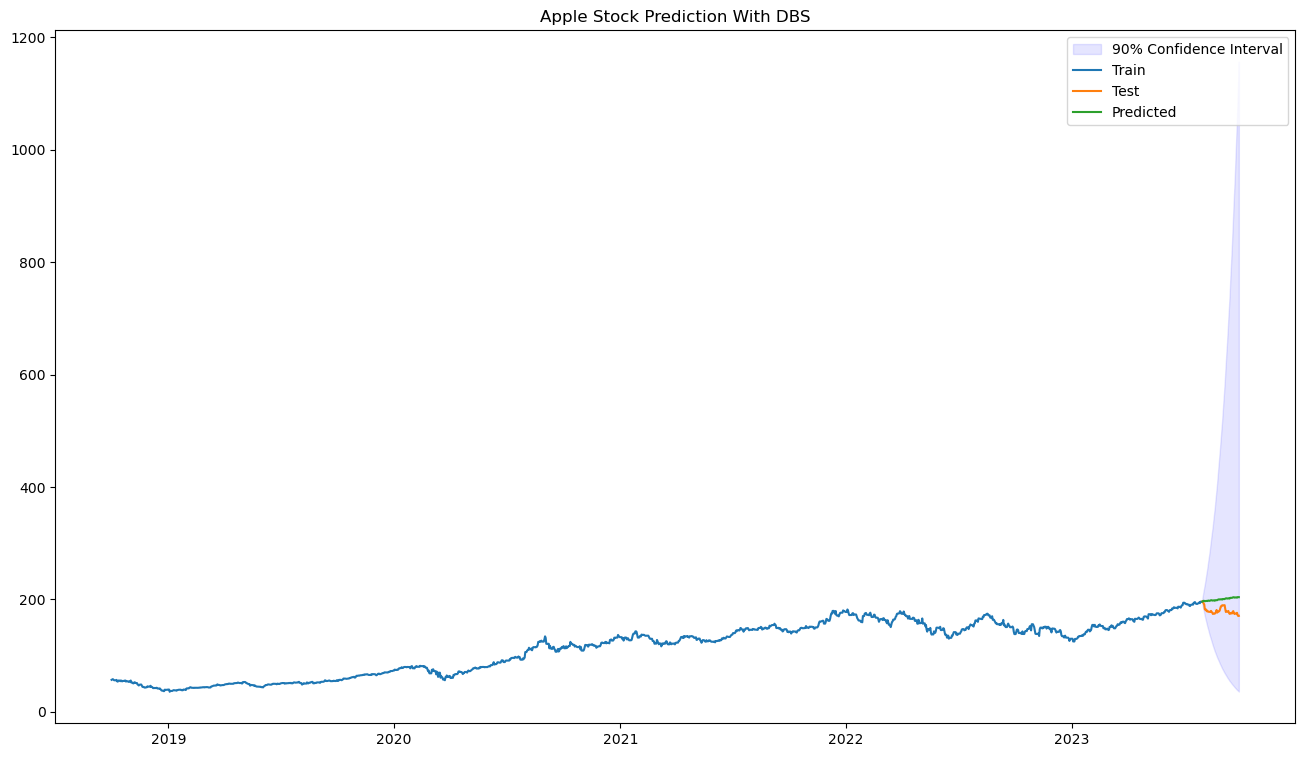

In [166]:
# Make predictions
pred = apple_w_dbs_result.predict(start=len(traindata_apple_unmodified)-1, 
                                            end=len(traindata_apple_unmodified)+58, exog=exog[['DBS']][len(appleADF)-60:])

forecast = apple_w_dbs_result.get_prediction(start=len(traindata_apple_unmodified)-1, 
                                            end=len(traindata_apple_unmodified)+58, exog=exog[['DBS']][len(appleADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_apple_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

apple_w_dbs['mse'] = mean_squared_error(testdata_apple_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_apple_unmodified.index, traindata_apple_unmodified, label='Train')
plt.plot(testdata_apple_unmodified.index, testdata_apple_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')


plt.legend()
plt.title('Apple Stock Prediction With DBS')
plt.show()


#### Apple with Amazon & DBS

In [167]:
apple_w_rest = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_apple, exog[['DBS','Amazon']][:len(appleADF)-60])

print(f"Best AIC: {apple_w_rest['best_aic']}")
print(f"Best (p, d, q) order: {apple_w_rest['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {apple_w_rest['best_seasonal_order']}")

Completed 1/16: Order (0, 0, 0), Seasonal Order (1, 1, 0, 12)
Completed 2/16: Order (0, 0, 0), Seasonal Order (1, 1, 1, 12)
Completed 3/16: Order (0, 0, 0), Seasonal Order (2, 1, 0, 12)
Completed 4/16: Order (0, 0, 0), Seasonal Order (2, 1, 1, 12)
Completed 5/16: Order (0, 0, 1), Seasonal Order (1, 1, 0, 12)
Completed 6/16: Order (0, 0, 1), Seasonal Order (1, 1, 1, 12)
Completed 7/16: Order (0, 0, 1), Seasonal Order (2, 1, 0, 12)
Completed 8/16: Order (0, 0, 1), Seasonal Order (2, 1, 1, 12)
Completed 9/16: Order (1, 0, 0), Seasonal Order (1, 1, 0, 12)
Completed 10/16: Order (1, 0, 0), Seasonal Order (1, 1, 1, 12)
Completed 11/16: Order (1, 0, 0), Seasonal Order (2, 1, 0, 12)
Completed 12/16: Order (1, 0, 0), Seasonal Order (2, 1, 1, 12)
Completed 13/16: Order (1, 0, 1), Seasonal Order (1, 1, 0, 12)
Completed 14/16: Order (1, 0, 1), Seasonal Order (1, 1, 1, 12)
Completed 15/16: Order (1, 0, 1), Seasonal Order (2, 1, 0, 12)
Completed 16/16: Order (1, 0, 1), Seasonal Order (2, 1, 1, 12)
B

In [168]:
apple_w_rest_model = SARIMAX(traindata_apple, order=apple_w_rest['best_order'], seasonal_order=apple_w_rest['best_seasonal_order'], exog=exog[['DBS','Amazon']][:len(appleADF)-60])
apple_w_rest_result = apple_w_rest_model.fit()

print(apple_w_rest_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Apple   No. Observations:                 1763
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood                5057.946
Date:                              Mon, 12 Feb 2024   AIC                         -10101.892
Time:                                      17:28:43   BIC                         -10063.616
Sample:                                  10-02-2018   HQIC                        -10087.743
                                       - 07-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DBS            0.0231      0.017      1.324      0.185      -0.011       0.057
Amazon         0.58

In [169]:
# Checking the residuals of the fitted model
residuals = apple_w_rest_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -41.766019
p-value (residuals): 0.000000


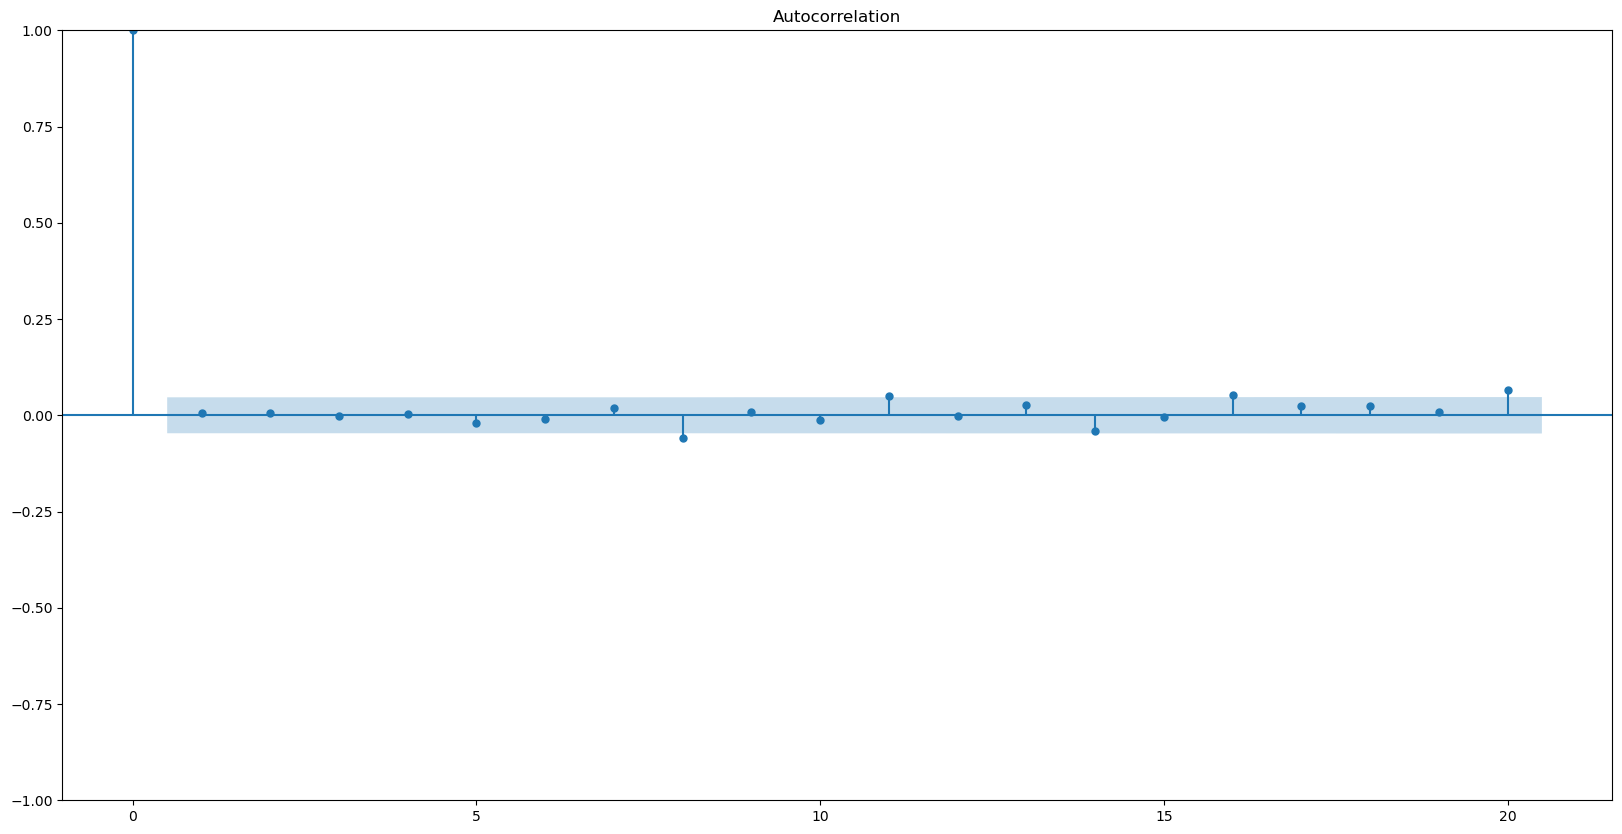

In [170]:
plot_acf(residuals, lags=20)
plt.show()

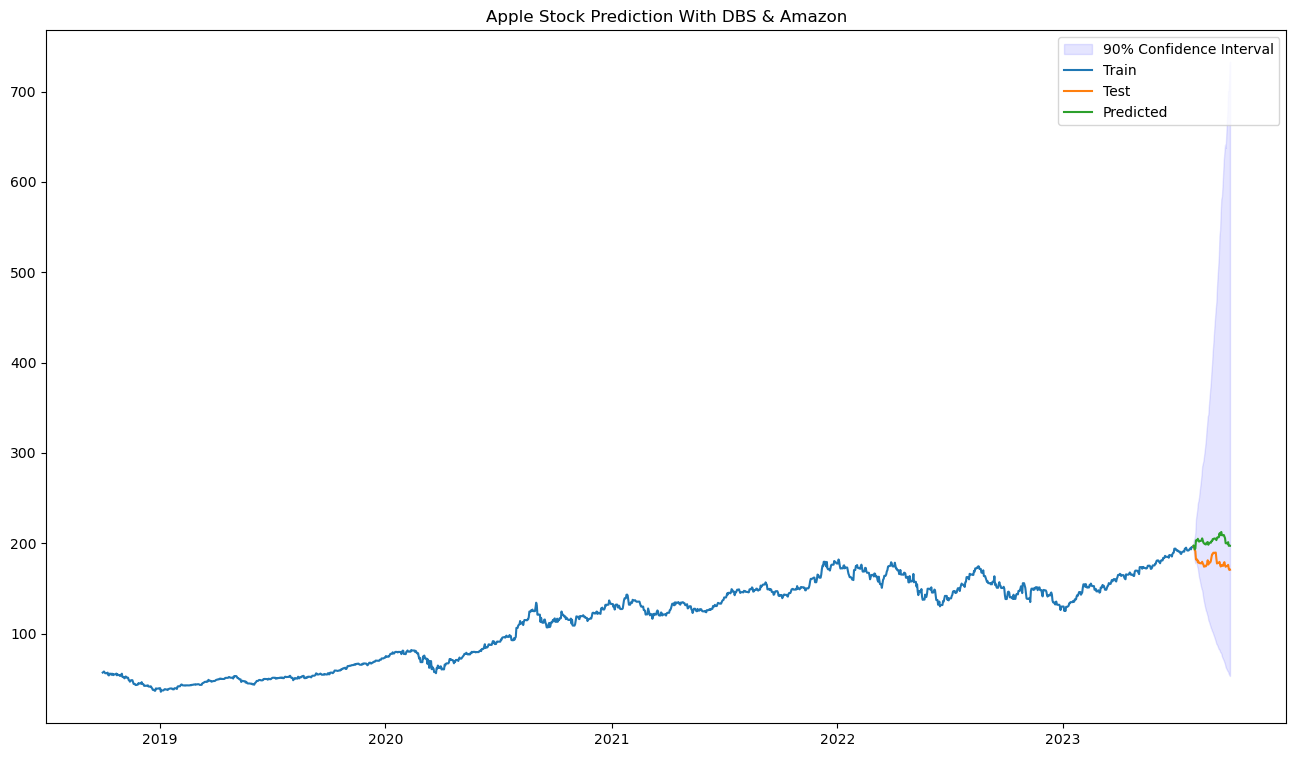

In [171]:

# Make predictions
pred = apple_w_rest_result.predict(start=len(traindata_apple_unmodified)-1, 
                                            end=len(traindata_apple_unmodified)+58, exog=exog[['DBS','Amazon']][len(appleADF)-60:])

forecast = apple_w_rest_result.get_prediction(start=len(traindata_apple_unmodified)-1, 
                                            end=len(traindata_apple_unmodified)+58, exog=exog[['DBS','Amazon']][len(appleADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_apple_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

apple_w_rest['mse'] = mean_squared_error(testdata_apple_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_apple_unmodified.index, traindata_apple_unmodified, label='Train')
plt.plot(testdata_apple_unmodified.index, testdata_apple_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')
plt.legend()
plt.title('Apple Stock Prediction With DBS & Amazon')
plt.show()


### DBS

In [172]:
traindata_dbs = dbsADF.iloc[:len(dbsADF)-60]
testdata_dbs = dbsADF.iloc[len(dbsADF)-60:]

#### DBS with Apple

In [173]:
p_values = range(0,2)
d_values = range(0,1)
q_values = range(0,2)
P_values = range(0,1)
D_values = [1]
Q_values = range(2)
s_values = [12]  # Assuming monthly data

dbs_w_apple = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_dbs, exog[['Apple']][:len(dbsADF)-60])

print(f"Best AIC: {dbs_w_apple['best_aic']}")
print(f"Best (p, d, q) order: {dbs_w_apple['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {dbs_w_apple['best_seasonal_order']}")

Completed 1/8: Order (0, 0, 0), Seasonal Order (0, 1, 0, 12)
Completed 2/8: Order (0, 0, 0), Seasonal Order (0, 1, 1, 12)
Completed 3/8: Order (0, 0, 1), Seasonal Order (0, 1, 0, 12)
Completed 4/8: Order (0, 0, 1), Seasonal Order (0, 1, 1, 12)
Completed 5/8: Order (1, 0, 0), Seasonal Order (0, 1, 0, 12)
Completed 6/8: Order (1, 0, 0), Seasonal Order (0, 1, 1, 12)
Completed 7/8: Order (1, 0, 1), Seasonal Order (0, 1, 0, 12)
Completed 8/8: Order (1, 0, 1), Seasonal Order (0, 1, 1, 12)
Best AIC: -10912.089399631797
Best (p, d, q) order: (0, 0, 0)
Best (P, D, Q, s) seasonal order: (0, 1, 1, 12)


In [174]:
dbs_w_apple_model = SARIMAX(traindata_dbs, order=dbs_w_apple['best_order'], seasonal_order=dbs_w_apple['best_seasonal_order'], exog=exog[['Apple']][:len(dbsADF)-60])
dbs_w_apple_result = dbs_w_apple_model.fit()

print(dbs_w_apple_result.summary())

                                 SARIMAX Results                                  
Dep. Variable:                        DBS   No. Observations:                 1763
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                5459.045
Date:                    Mon, 12 Feb 2024   AIC                         -10912.089
Time:                            17:29:13   BIC                         -10895.686
Sample:                        10-02-2018   HQIC                        -10906.026
                             - 07-30-2023                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.0208      0.008      2.698      0.007       0.006       0.036
ma.S.L12      -0.9997      0.391     -2.555      0.011      -1.766      -0.233
sigma2         0.000

In [175]:
# Checking the residuals of the fitted model
residuals = dbs_w_apple_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -12.815837
p-value (residuals): 0.000000


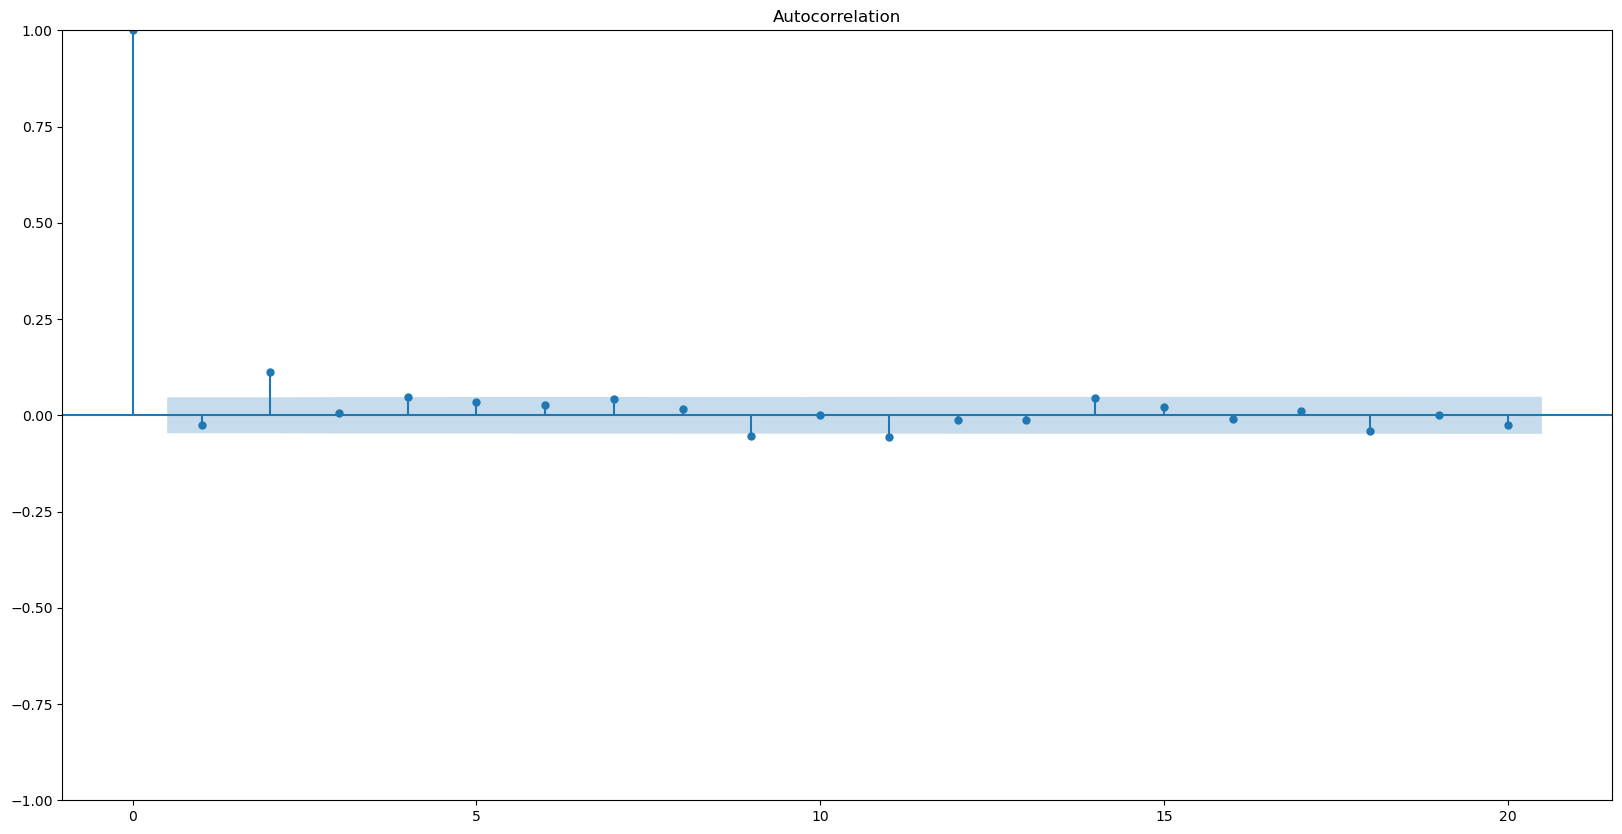

In [176]:
plot_acf(residuals, lags=20)
plt.show()

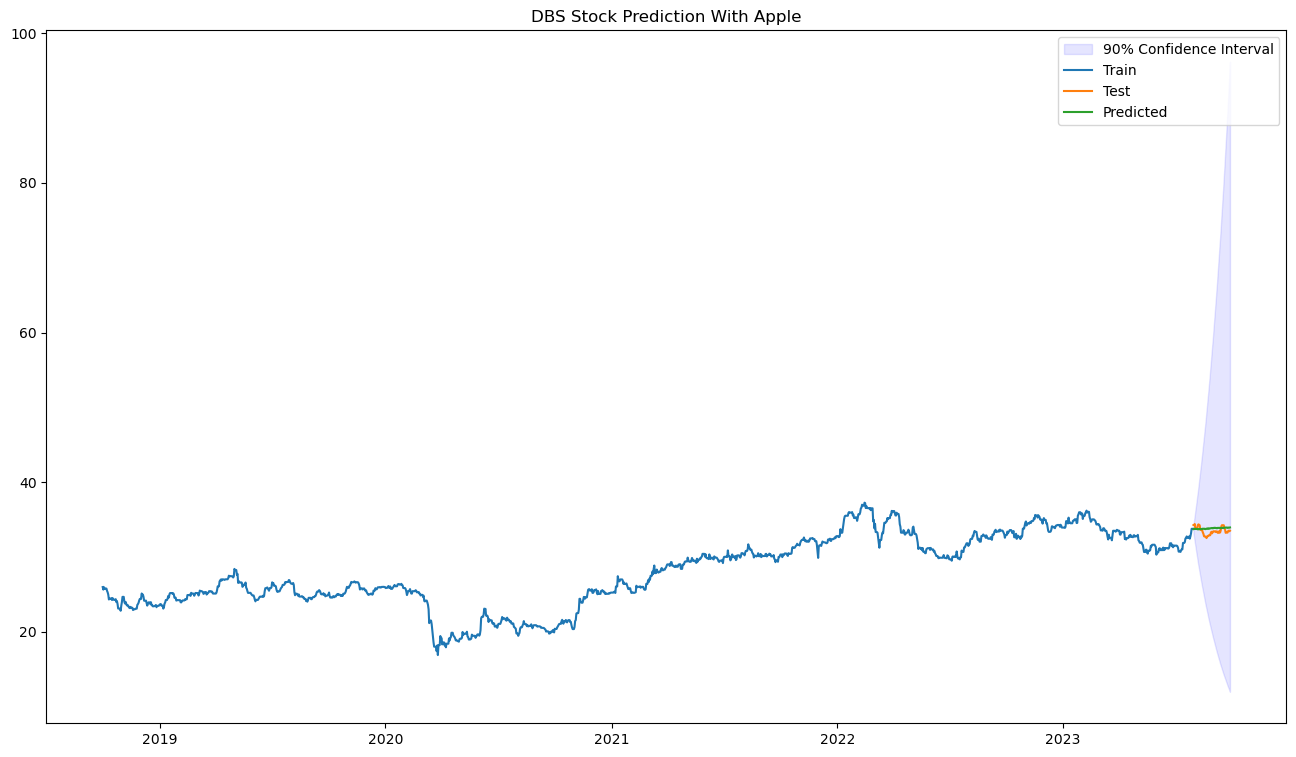

In [177]:

traindata_dbs_unmodified = df['DBS'].iloc[:len(df['DBS'])-60]
testdata_dbs_unmodified = df['DBS'].iloc[len(df['DBS'])-60:]
# Make predictions
pred = dbs_w_apple_result.predict(start=len(traindata_dbs_unmodified)-1, 
                                            end=len(traindata_dbs_unmodified)+58, exog=exog[['Apple']][len(dbsADF)-60:])

forecast = dbs_w_apple_result.get_prediction(start=len(traindata_dbs_unmodified)-1, 
                                            end=len(traindata_dbs_unmodified)+58, exog=exog[['Apple']][len(dbsADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_dbs_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

dbs_w_apple['mse'] = mean_squared_error(testdata_dbs_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_dbs_unmodified.index, traindata_dbs_unmodified, label='Train')
plt.plot(testdata_dbs_unmodified.index, testdata_dbs_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')
plt.legend()
plt.title('DBS Stock Prediction With Apple')
plt.show()



#### DBS with Amazon

In [178]:
dbs_w_amazon = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_dbs, exog[['Amazon']][:len(dbsADF)-60])

print(f"Best AIC: {dbs_w_amazon['best_aic']}")
print(f"Best (p, d, q) order: {dbs_w_amazon['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {dbs_w_amazon['best_seasonal_order']}")

Completed 1/8: Order (0, 0, 0), Seasonal Order (0, 1, 0, 12)
Completed 2/8: Order (0, 0, 0), Seasonal Order (0, 1, 1, 12)
Completed 3/8: Order (0, 0, 1), Seasonal Order (0, 1, 0, 12)
Completed 4/8: Order (0, 0, 1), Seasonal Order (0, 1, 1, 12)
Completed 5/8: Order (1, 0, 0), Seasonal Order (0, 1, 0, 12)
Completed 6/8: Order (1, 0, 0), Seasonal Order (0, 1, 1, 12)
Completed 7/8: Order (1, 0, 1), Seasonal Order (0, 1, 0, 12)
Completed 8/8: Order (1, 0, 1), Seasonal Order (0, 1, 1, 12)
Best AIC: -10915.584162387695
Best (p, d, q) order: (1, 0, 1)
Best (P, D, Q, s) seasonal order: (0, 1, 1, 12)


In [179]:
dbs_w_amazon_model = SARIMAX(traindata_dbs, order=dbs_w_amazon['best_order'], seasonal_order=dbs_w_amazon['best_seasonal_order'], exog=exog[['Amazon']][:len(dbsADF)-60])
dbs_w_amazon_result = dbs_w_amazon_model.fit()

print(dbs_w_amazon_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                DBS   No. Observations:                 1763
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                5462.792
Date:                            Mon, 12 Feb 2024   AIC                         -10915.584
Time:                                    17:29:46   BIC                         -10888.244
Sample:                                10-02-2018   HQIC                        -10905.478
                                     - 07-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Amazon         0.0205      0.009      2.225      0.026       0.002       0.039
ar.L1          0.7565      0.116   

In [180]:
# Checking the residuals of the fitted model
residuals = dbs_w_amazon_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -28.214523
p-value (residuals): 0.000000


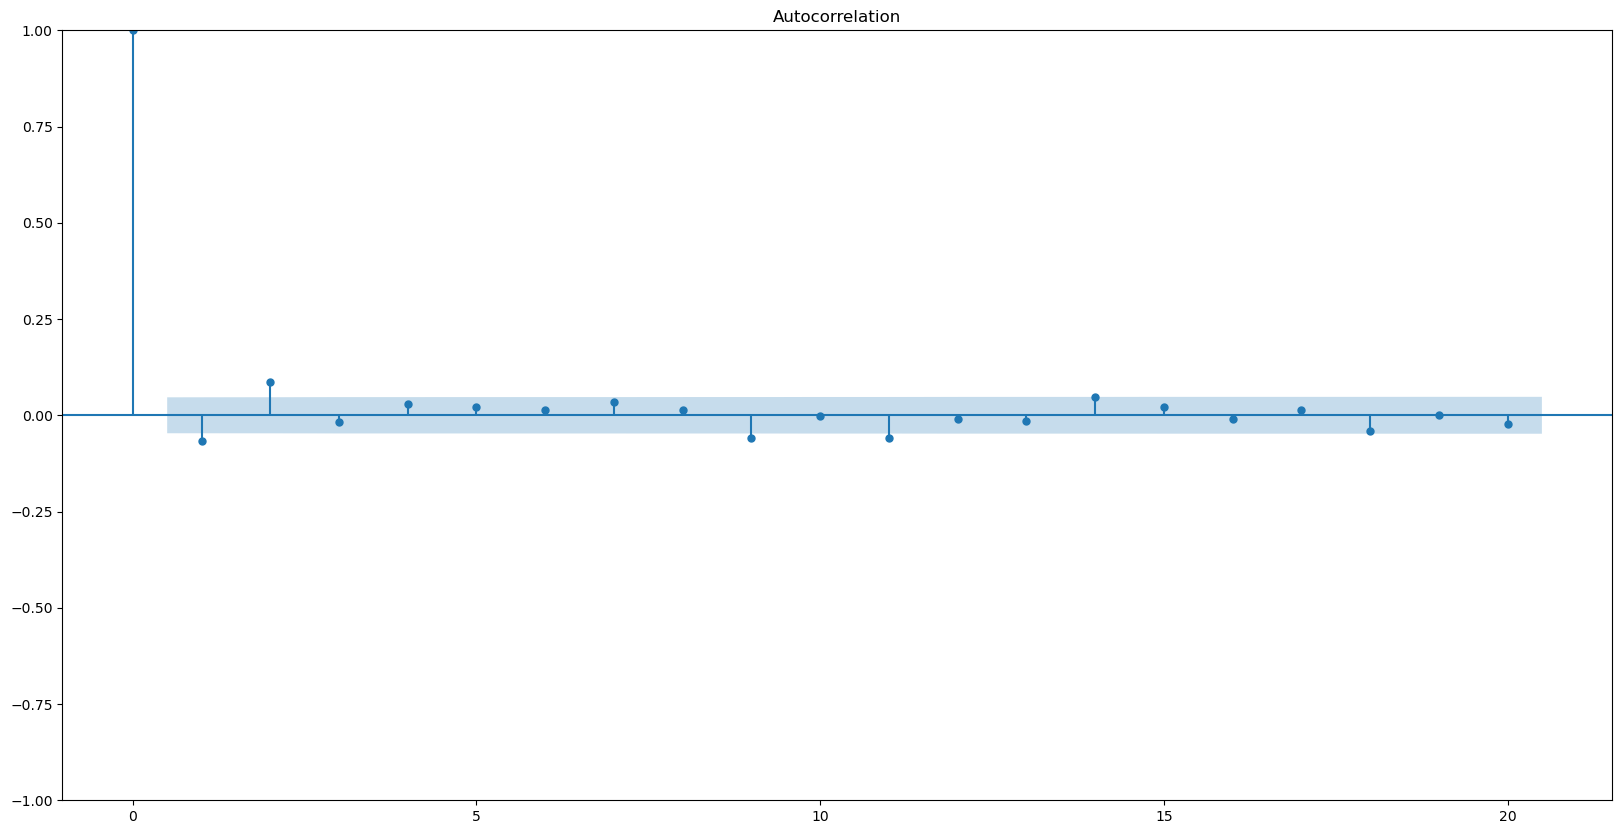

In [181]:
plot_acf(residuals, lags=20)
plt.show()

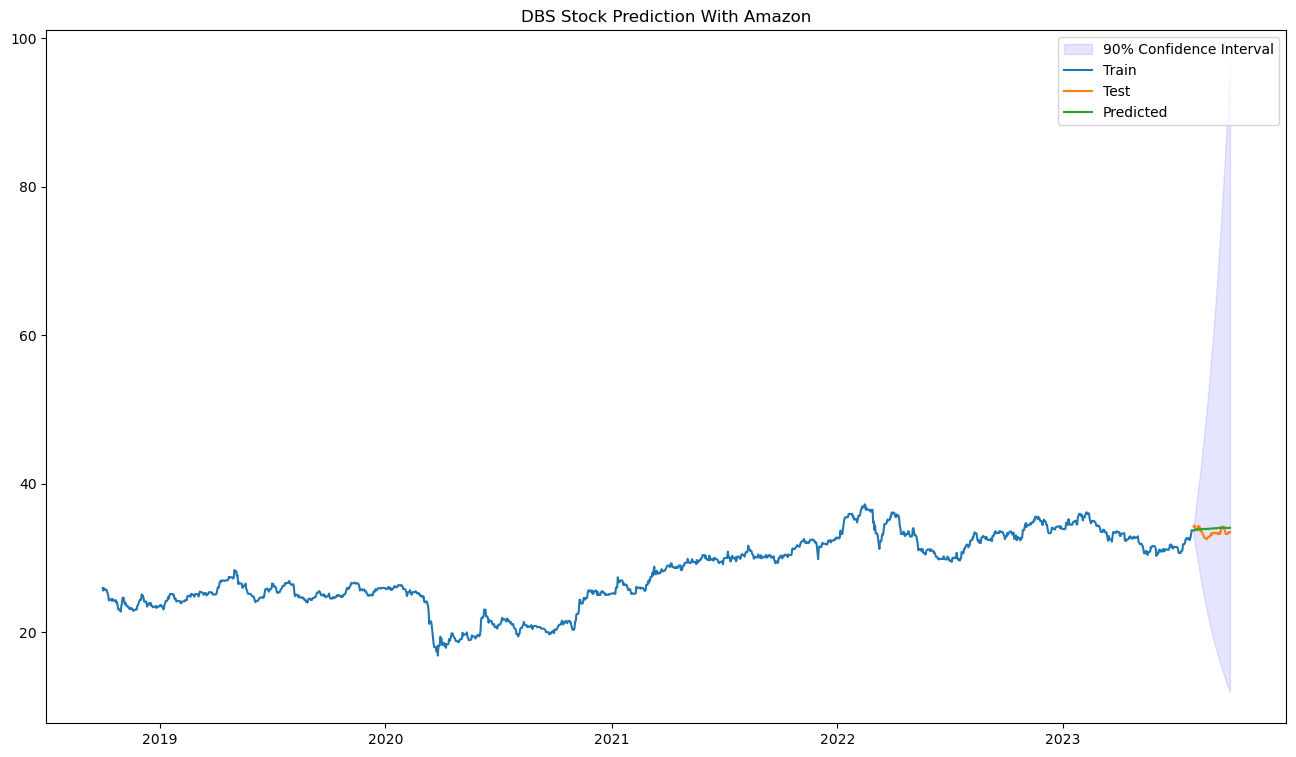

In [182]:
# Make predictions
pred = dbs_w_amazon_result.predict(start=len(traindata_dbs_unmodified)-1, 
                                            end=len(traindata_dbs_unmodified)+58, exog=exog[['Amazon']][len(dbsADF)-60:])

forecast = dbs_w_amazon_result.get_prediction(start=len(traindata_dbs_unmodified)-1, 
                                            end=len(traindata_dbs_unmodified)+58, exog=exog[['Amazon']][len(dbsADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_dbs_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

dbs_w_amazon['mse'] = mean_squared_error(testdata_dbs_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_dbs_unmodified.index, traindata_dbs_unmodified, label='Train')
plt.plot(testdata_dbs_unmodified.index, testdata_dbs_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')
plt.legend()
plt.title('DBS Stock Prediction With Amazon')
plt.show()



#### DBS with Apple & Amazon

In [183]:
dbs_w_rest = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_dbs, exog[['Apple','Amazon']][:len(dbsADF)-60])

print(f"Best AIC: {dbs_w_rest['best_aic']}")
print(f"Best (p, d, q) order: {dbs_w_rest['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {dbs_w_rest['best_seasonal_order']}")

Completed 1/8: Order (0, 0, 0), Seasonal Order (0, 1, 0, 12)
Completed 2/8: Order (0, 0, 0), Seasonal Order (0, 1, 1, 12)
Completed 3/8: Order (0, 0, 1), Seasonal Order (0, 1, 0, 12)
Completed 4/8: Order (0, 0, 1), Seasonal Order (0, 1, 1, 12)
Completed 5/8: Order (1, 0, 0), Seasonal Order (0, 1, 0, 12)
Completed 6/8: Order (1, 0, 0), Seasonal Order (0, 1, 1, 12)
Completed 7/8: Order (1, 0, 1), Seasonal Order (0, 1, 0, 12)
Completed 8/8: Order (1, 0, 1), Seasonal Order (0, 1, 1, 12)
Best AIC: -10911.264459153295
Best (p, d, q) order: (0, 0, 0)
Best (P, D, Q, s) seasonal order: (0, 1, 1, 12)


In [184]:
dbs_w_rest_model = SARIMAX(traindata_dbs, order=dbs_w_rest['best_order'], seasonal_order=dbs_w_rest['best_seasonal_order'], exog=exog[['Apple','Amazon']][:len(dbsADF)-60])
dbs_w_rest_result = dbs_w_rest_model.fit()

print(dbs_w_rest_result.summary())

                                 SARIMAX Results                                  
Dep. Variable:                        DBS   No. Observations:                 1763
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                5459.632
Date:                    Mon, 12 Feb 2024   AIC                         -10911.264
Time:                            17:30:18   BIC                         -10889.393
Sample:                        10-02-2018   HQIC                        -10903.180
                             - 07-30-2023                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.0074      0.011      0.642      0.521      -0.015       0.030
Amazon         0.0188      0.013      1.438      0.150      -0.007       0.044
ma.S.L12      -0.999

In [185]:
# Checking the residuals of the fitted model
residuals = dbs_w_rest_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -12.824416
p-value (residuals): 0.000000


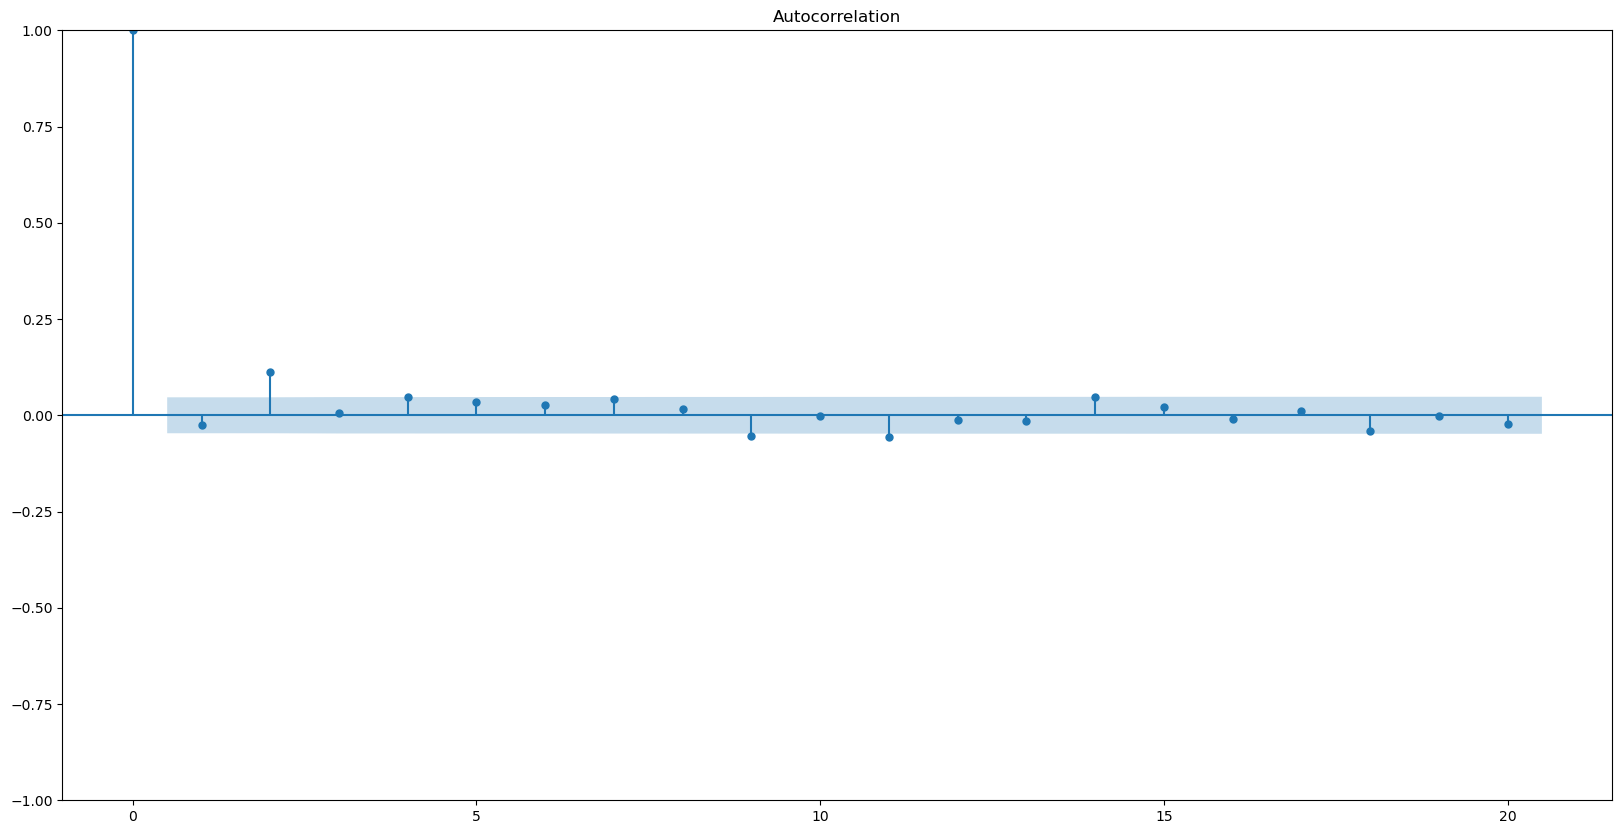

In [186]:
plot_acf(residuals, lags=20)
plt.show()

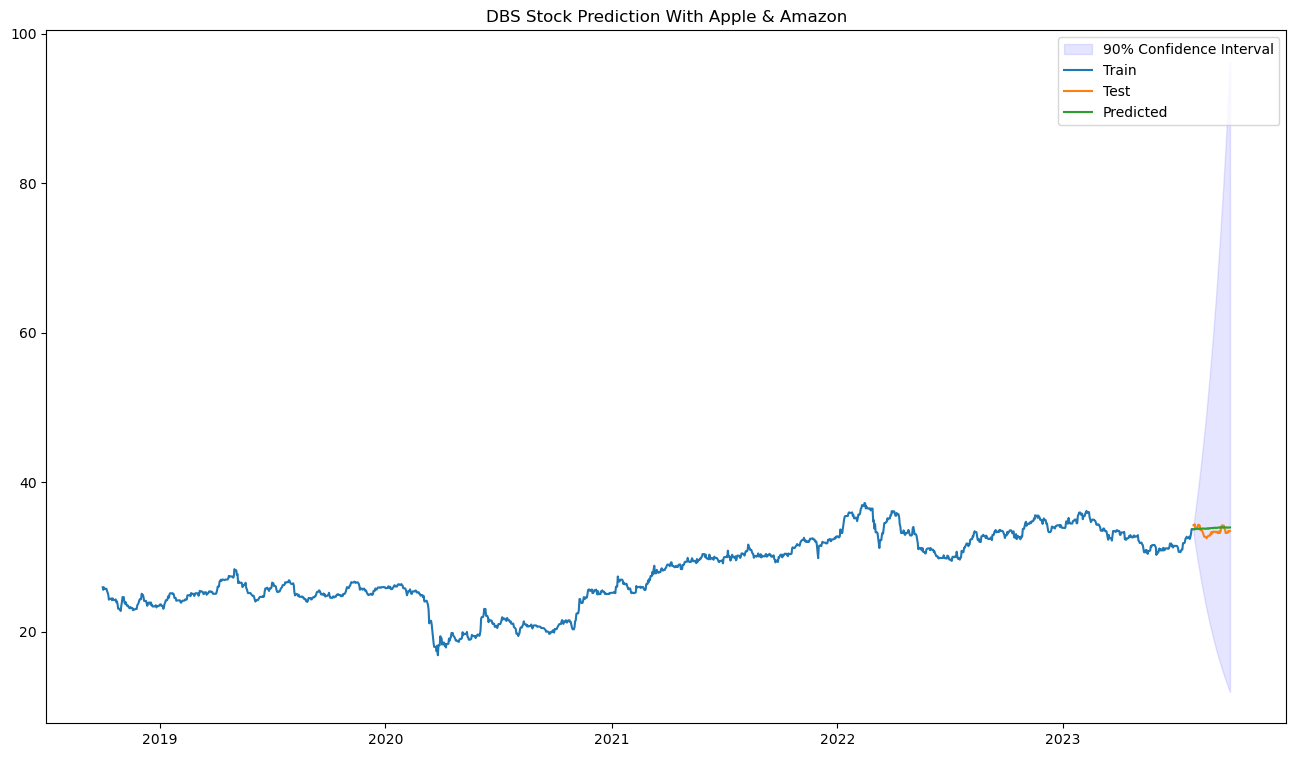

In [187]:
# Make predictions
pred = dbs_w_rest_result.predict(start=len(traindata_dbs_unmodified)-1, 
                                            end=len(traindata_dbs_unmodified)+58, exog=exog[['Apple','Amazon']][len(dbsADF)-60:])

forecast = dbs_w_rest_result.get_prediction(start=len(traindata_dbs_unmodified)-1, 
                                            end=len(traindata_dbs_unmodified)+58, exog=exog[['Apple','Amazon']][len(dbsADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_dbs_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

dbs_w_rest['mse'] = mean_squared_error(testdata_dbs_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_dbs_unmodified.index, traindata_dbs_unmodified, label='Train')
plt.plot(testdata_dbs_unmodified.index, testdata_dbs_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')
plt.legend()
plt.title('DBS Stock Prediction With Apple & Amazon')
plt.show()



### Amazon

In [188]:
traindata_amazon = amazonADF.iloc[:len(amazonADF)-60]
testdata_amazon = amazonADF.iloc[len(amazonADF)-60:]

#### Amazon with Apple

In [189]:
p_values = range(1,3)
d_values = range(0,1)
q_values = range(0,2)
P_values = range(1,3)
D_values = [2]
Q_values = range(2)
s_values = [12]  # Assuming monthly data

amazon_w_apple = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_amazon, exog[['Apple']][:len(amazonADF)-60])

print(f"Best AIC: {amazon_w_apple['best_aic']}")
print(f"Best (p, d, q) order: {amazon_w_apple['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {amazon_w_apple['best_seasonal_order']}")

Completed 1/16: Order (1, 0, 0), Seasonal Order (1, 2, 0, 12)
Completed 2/16: Order (1, 0, 0), Seasonal Order (1, 2, 1, 12)
Completed 3/16: Order (1, 0, 0), Seasonal Order (2, 2, 0, 12)
Completed 4/16: Order (1, 0, 0), Seasonal Order (2, 2, 1, 12)
Completed 5/16: Order (1, 0, 1), Seasonal Order (1, 2, 0, 12)
Completed 6/16: Order (1, 0, 1), Seasonal Order (1, 2, 1, 12)
Completed 7/16: Order (1, 0, 1), Seasonal Order (2, 2, 0, 12)
Completed 8/16: Order (1, 0, 1), Seasonal Order (2, 2, 1, 12)
Completed 9/16: Order (2, 0, 0), Seasonal Order (1, 2, 0, 12)
Completed 10/16: Order (2, 0, 0), Seasonal Order (1, 2, 1, 12)
Completed 11/16: Order (2, 0, 0), Seasonal Order (2, 2, 0, 12)
Completed 12/16: Order (2, 0, 0), Seasonal Order (2, 2, 1, 12)
Completed 13/16: Order (2, 0, 1), Seasonal Order (1, 2, 0, 12)
Completed 14/16: Order (2, 0, 1), Seasonal Order (1, 2, 1, 12)
Completed 15/16: Order (2, 0, 1), Seasonal Order (2, 2, 0, 12)
Completed 16/16: Order (2, 0, 1), Seasonal Order (2, 2, 1, 12)
B

In [190]:
amazon_w_apple_model = SARIMAX(traindata_amazon, order=amazon_w_apple['best_order'], seasonal_order=amazon_w_apple['best_seasonal_order'], exog=exog[['Apple']][:len(amazonADF)-60])
amazon_w_apple_result = amazon_w_apple_model.fit()

print(amazon_w_apple_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               Amazon   No. Observations:                 1763
Model:             SARIMAX(1, 0, 0)x(2, 2, [1], 12)   Log Likelihood                4596.483
Date:                              Mon, 12 Feb 2024   AIC                          -9180.965
Time:                                      17:40:34   BIC                          -9148.199
Sample:                                  10-02-2018   HQIC                         -9168.849
                                       - 07-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.7218      0.013     53.601      0.000       0.695       0.748
ar.L1         -0.01

In [191]:
# Checking the residuals of the fitted model
residuals = amazon_w_apple_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -10.219281
p-value (residuals): 0.000000


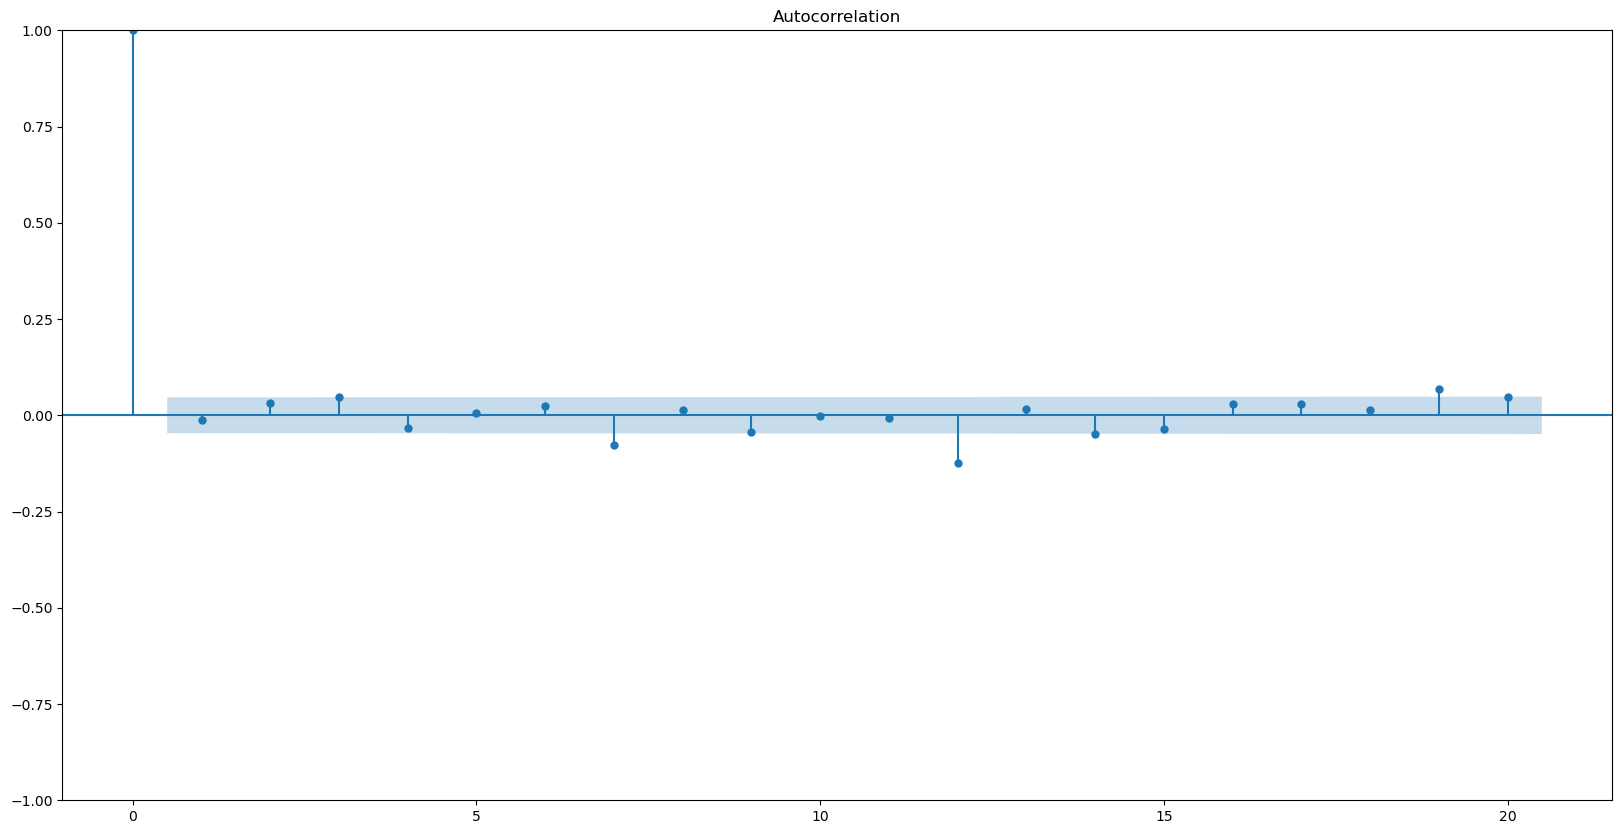

In [192]:
plot_acf(residuals, lags=20)
plt.show()

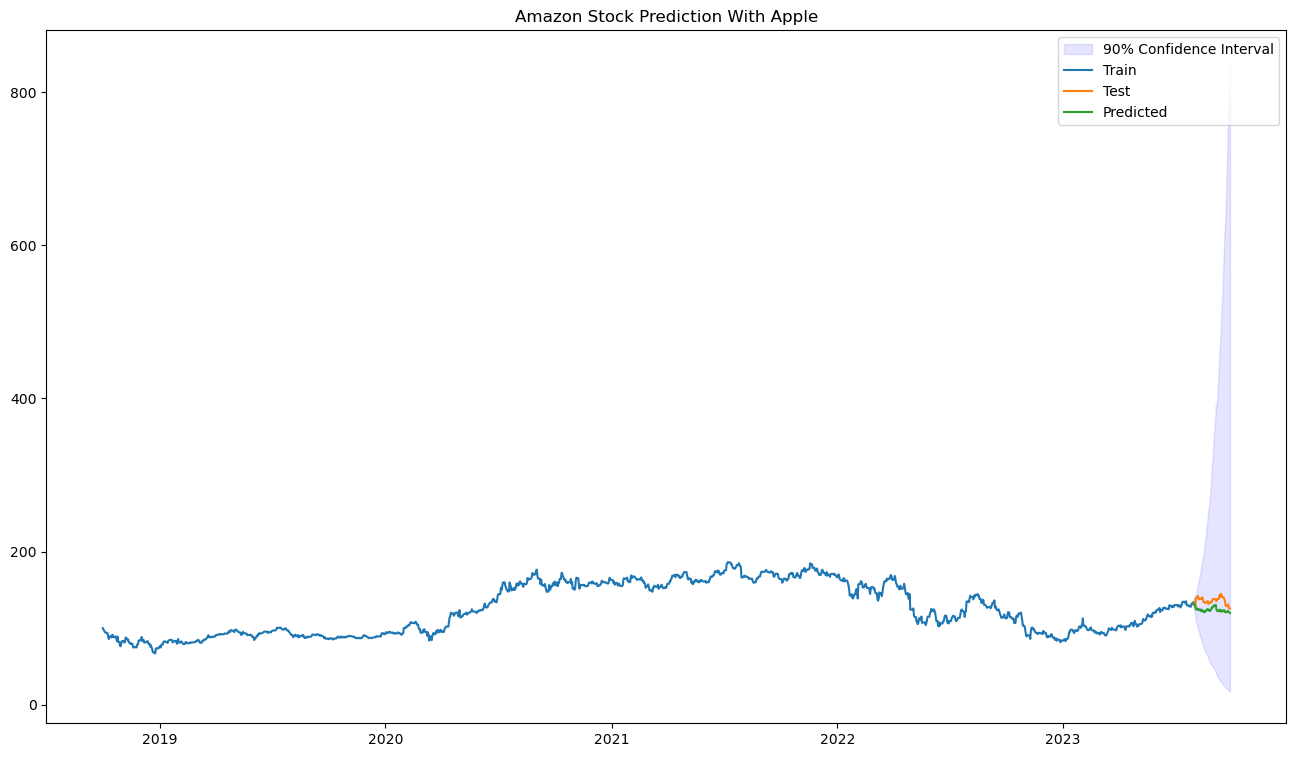

In [193]:

traindata_amazon_unmodified = df['Amazon'].iloc[:len(df['Amazon'])-60]
testdata_amazon_unmodified = df['Amazon'].iloc[len(df['Amazon'])-60:]

# Make predictions
pred = amazon_w_apple_result.predict(start=len(traindata_amazon_unmodified)-1, 
                                            end=len(traindata_amazon_unmodified)+58, exog=exog[['Apple']][len(amazonADF)-60:])

forecast = amazon_w_apple_result.get_prediction(start=len(traindata_amazon_unmodified)-1, 
                                            end=len(traindata_amazon_unmodified)+58, exog=exog[['Apple']][len(amazonADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_amazon_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

amazon_w_apple['mse'] = mean_squared_error(testdata_amazon_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_amazon_unmodified.index, traindata_amazon_unmodified, label='Train')
plt.plot(testdata_amazon_unmodified.index, testdata_amazon_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')
plt.legend()
plt.title('Amazon Stock Prediction With Apple')
plt.show()



#### Amazon with DBS

In [194]:
amazon_w_dbs = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_amazon, exog[['DBS']][:len(amazonADF)-60])

print(f"Best AIC: {amazon_w_dbs['best_aic']}")
print(f"Best (p, d, q) order: {amazon_w_dbs['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {amazon_w_dbs['best_seasonal_order']}")

Completed 1/16: Order (1, 0, 0), Seasonal Order (1, 2, 0, 12)
Completed 2/16: Order (1, 0, 0), Seasonal Order (1, 2, 1, 12)
Completed 3/16: Order (1, 0, 0), Seasonal Order (2, 2, 0, 12)
Completed 4/16: Order (1, 0, 0), Seasonal Order (2, 2, 1, 12)
Completed 5/16: Order (1, 0, 1), Seasonal Order (1, 2, 0, 12)
Completed 6/16: Order (1, 0, 1), Seasonal Order (1, 2, 1, 12)
Completed 7/16: Order (1, 0, 1), Seasonal Order (2, 2, 0, 12)
Completed 8/16: Order (1, 0, 1), Seasonal Order (2, 2, 1, 12)
Completed 9/16: Order (2, 0, 0), Seasonal Order (1, 2, 0, 12)
Completed 10/16: Order (2, 0, 0), Seasonal Order (1, 2, 1, 12)
Completed 11/16: Order (2, 0, 0), Seasonal Order (2, 2, 0, 12)
Completed 12/16: Order (2, 0, 0), Seasonal Order (2, 2, 1, 12)
Completed 13/16: Order (2, 0, 1), Seasonal Order (1, 2, 0, 12)
Completed 14/16: Order (2, 0, 1), Seasonal Order (1, 2, 1, 12)
Completed 15/16: Order (2, 0, 1), Seasonal Order (2, 2, 0, 12)
Completed 16/16: Order (2, 0, 1), Seasonal Order (2, 2, 1, 12)
B

In [195]:
amazon_w_dbs_model = SARIMAX(traindata_amazon, order=amazon_w_dbs['best_order'], seasonal_order=amazon_w_dbs['best_seasonal_order'], exog=exog[['DBS']][:len(amazonADF)-60])
amazon_w_dbs_result = amazon_w_dbs_model.fit()

print(amazon_w_dbs_result.summary()) 

                                      SARIMAX Results                                       
Dep. Variable:                               Amazon   No. Observations:                 1763
Model:             SARIMAX(2, 0, 0)x(2, 2, [1], 12)   Log Likelihood                4105.342
Date:                              Mon, 12 Feb 2024   AIC                          -8196.684
Time:                                      17:49:12   BIC                          -8158.457
Sample:                                  10-02-2018   HQIC                         -8182.548
                                       - 07-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DBS            0.0585      0.033      1.765      0.078      -0.006       0.124
ar.L1         -0.06

In [196]:
# Checking the residuals of the fitted model
residuals = amazon_w_dbs_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -10.199411
p-value (residuals): 0.000000


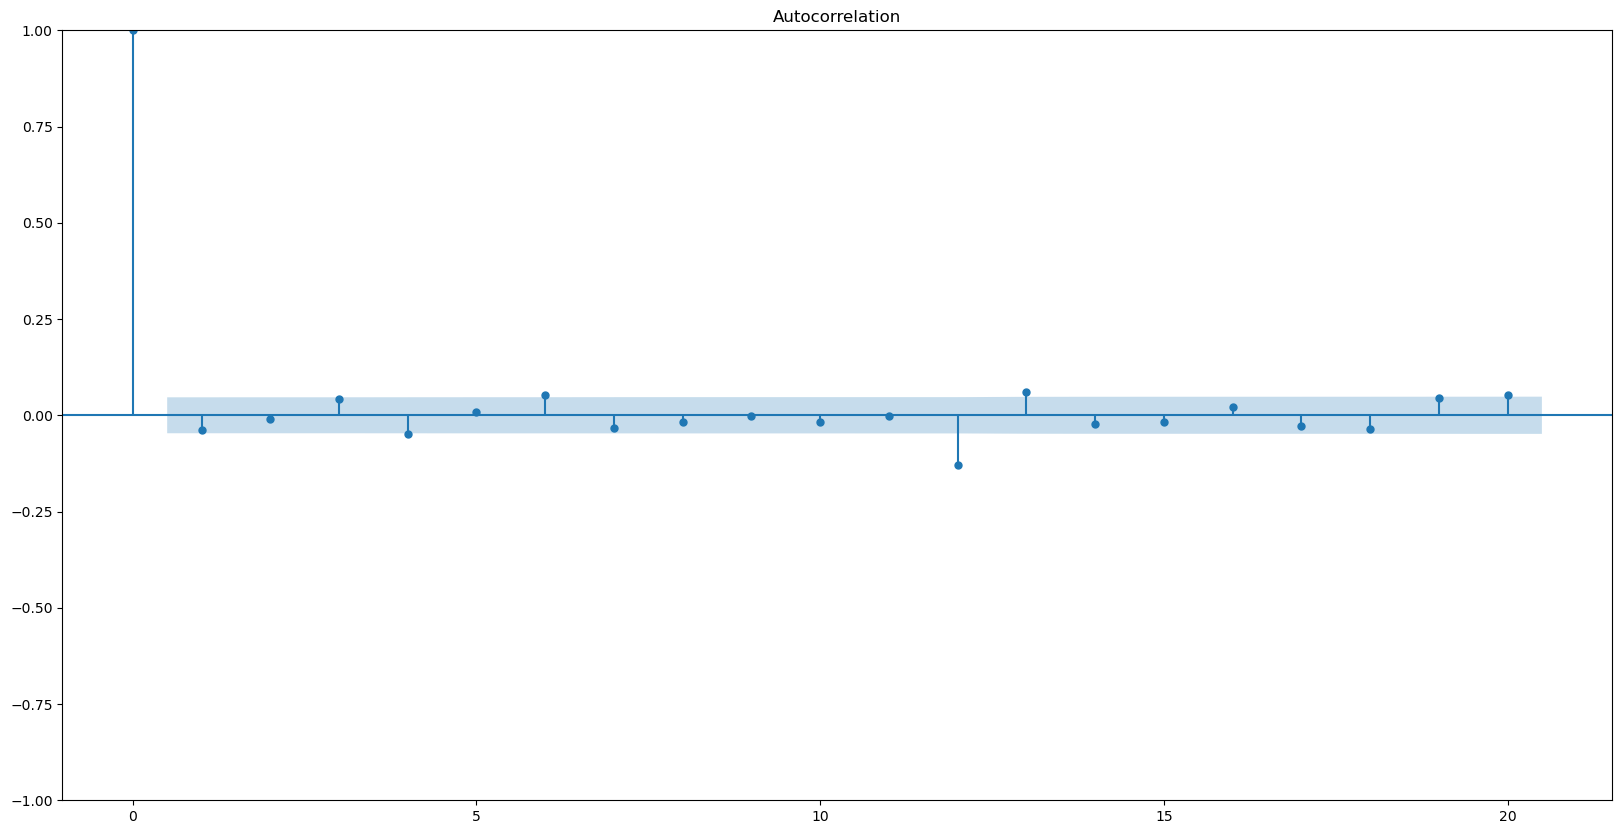

In [197]:
plot_acf(residuals, lags=20)
plt.show()

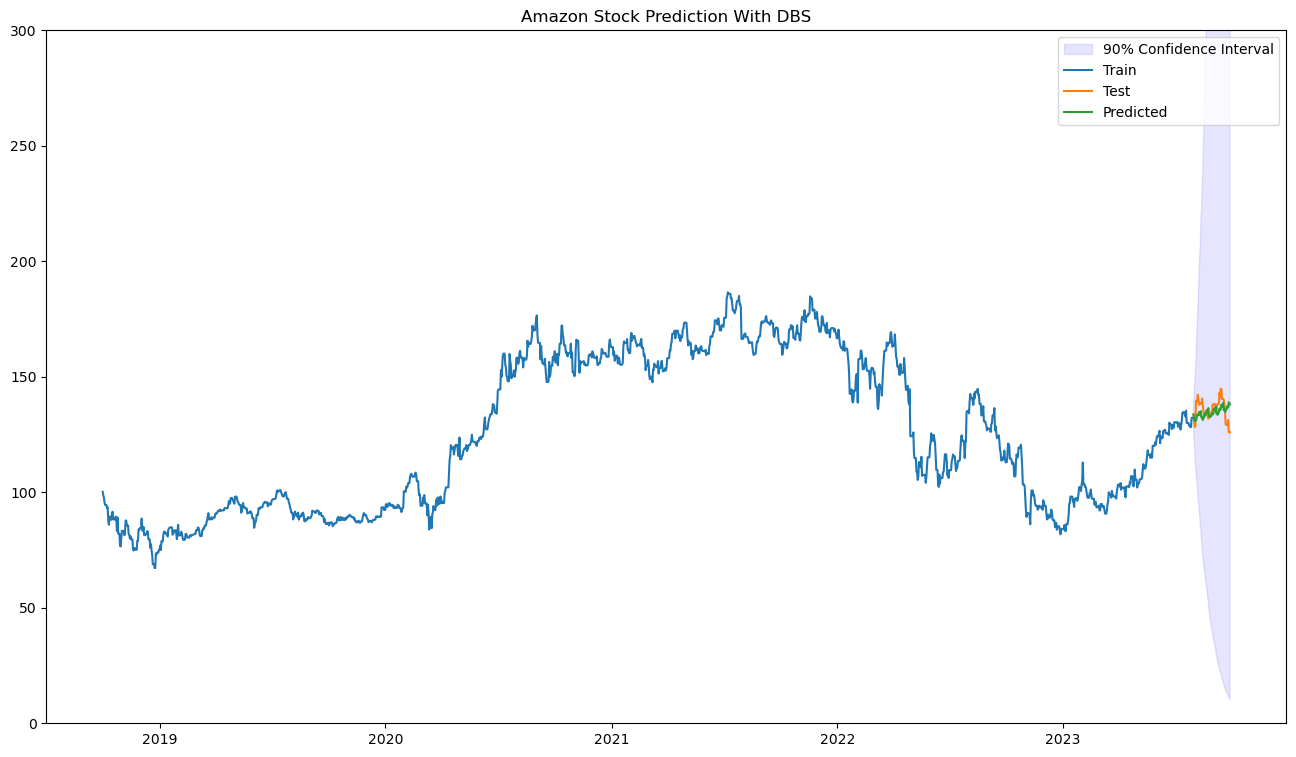

In [198]:

# Make predictions
pred = amazon_w_dbs_result.predict(start=len(traindata_amazon_unmodified)-1, 
                                            end=len(traindata_amazon_unmodified)+58, exog=exog[['DBS']][len(amazonADF)-60:])

forecast = amazon_w_dbs_result.get_prediction(start=len(traindata_amazon_unmodified)-1, 
                                            end=len(traindata_amazon_unmodified)+58, exog=exog[['DBS']][len(amazonADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_amazon_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

amazon_w_dbs['mse'] = mean_squared_error(testdata_amazon_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_amazon_unmodified.index, traindata_amazon_unmodified, label='Train')
plt.plot(testdata_amazon_unmodified.index, testdata_amazon_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')
plt.legend()
plt.ylim(0,300)
plt.title('Amazon Stock Prediction With DBS')
plt.show()



#### Amazon with Apple & DBS

In [199]:
amazon_w_rest = manual_sarimax(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, traindata_amazon, exog[['Apple','DBS']][:len(amazonADF)-60])

print(f"Best AIC: {amazon_w_rest['best_aic']}")
print(f"Best (p, d, q) order: {amazon_w_rest['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {amazon_w_rest['best_seasonal_order']}")

Completed 1/16: Order (1, 0, 0), Seasonal Order (1, 2, 0, 12)
Completed 2/16: Order (1, 0, 0), Seasonal Order (1, 2, 1, 12)
Completed 3/16: Order (1, 0, 0), Seasonal Order (2, 2, 0, 12)
Completed 4/16: Order (1, 0, 0), Seasonal Order (2, 2, 1, 12)
Completed 5/16: Order (1, 0, 1), Seasonal Order (1, 2, 0, 12)
Completed 6/16: Order (1, 0, 1), Seasonal Order (1, 2, 1, 12)
Completed 7/16: Order (1, 0, 1), Seasonal Order (2, 2, 0, 12)
Completed 8/16: Order (1, 0, 1), Seasonal Order (2, 2, 1, 12)
Completed 9/16: Order (2, 0, 0), Seasonal Order (1, 2, 0, 12)
Completed 10/16: Order (2, 0, 0), Seasonal Order (1, 2, 1, 12)
Completed 11/16: Order (2, 0, 0), Seasonal Order (2, 2, 0, 12)
Completed 12/16: Order (2, 0, 0), Seasonal Order (2, 2, 1, 12)
Completed 13/16: Order (2, 0, 1), Seasonal Order (1, 2, 0, 12)
Completed 14/16: Order (2, 0, 1), Seasonal Order (1, 2, 1, 12)
Completed 15/16: Order (2, 0, 1), Seasonal Order (2, 2, 0, 12)
Completed 16/16: Order (2, 0, 1), Seasonal Order (2, 2, 1, 12)
B

In [200]:
amazon_w_rest_model = SARIMAX(traindata_amazon, order=amazon_w_rest['best_order'], seasonal_order=amazon_w_rest['best_seasonal_order'], exog=exog[['Apple','DBS']][:len(amazonADF)-60])
amazon_w_rest_result = amazon_w_rest_model.fit()

print(amazon_w_rest_result.summary()) 

                                      SARIMAX Results                                       
Dep. Variable:                               Amazon   No. Observations:                 1763
Model:             SARIMAX(1, 0, 0)x(2, 2, [1], 12)   Log Likelihood                4596.608
Date:                              Mon, 12 Feb 2024   AIC                          -9179.215
Time:                                      17:58:54   BIC                          -9140.988
Sample:                                  10-02-2018   HQIC                         -9165.080
                                       - 07-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.7216      0.014     53.379      0.000       0.695       0.748
DBS            0.01

In [201]:
# Checking the residuals of the fitted model
residuals = amazon_w_rest_result.resid
adf_test_resid = adfuller(residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -10.203128
p-value (residuals): 0.000000


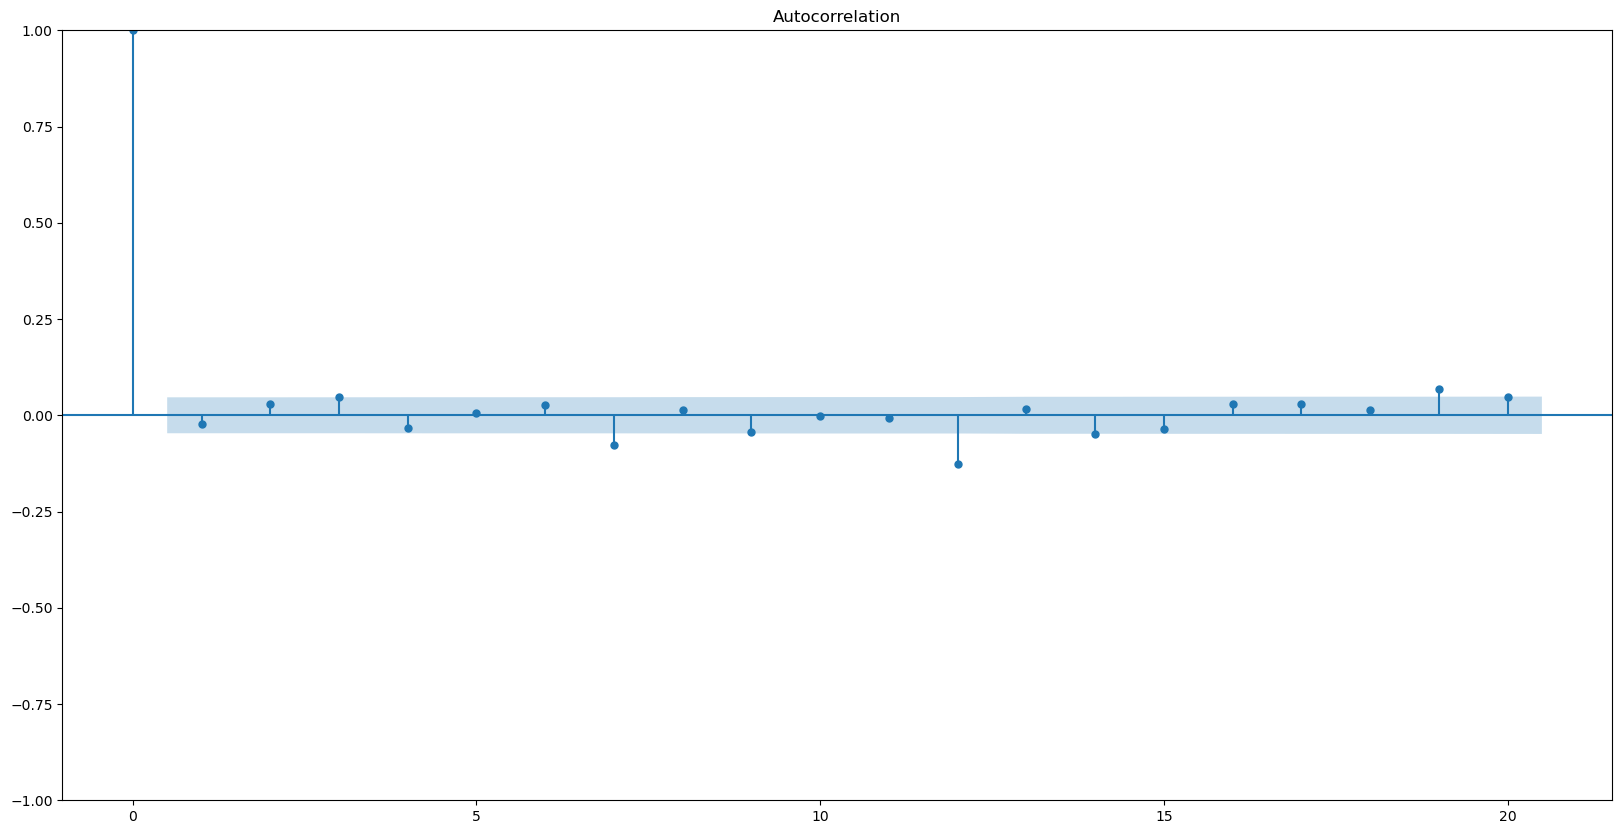

In [202]:
plot_acf(residuals, lags=20)
plt.show()

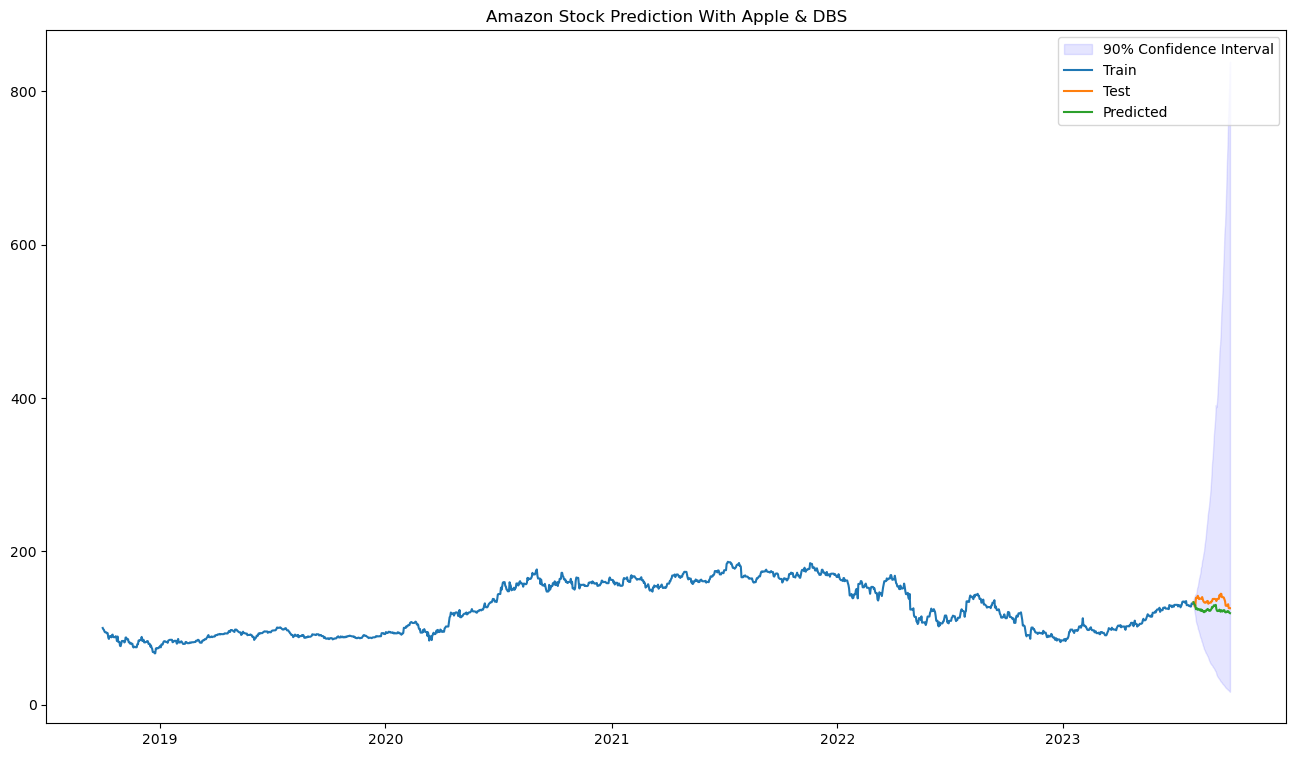

In [203]:

# Make predictions
pred = amazon_w_rest_result.predict(start=len(traindata_amazon_unmodified)-1, 
                                            end=len(traindata_amazon_unmodified)+58, exog=exog[['Apple','DBS']][len(amazonADF)-60:])

forecast = amazon_w_rest_result.get_prediction(start=len(traindata_amazon_unmodified)-1, 
                                            end=len(traindata_amazon_unmodified)+58, exog=exog[['Apple','DBS']][len(amazonADF)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = traindata_amazon_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(pred, 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_lower'] = np.cumsum(np.insert(forecast['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast['mean_ci_upper'] = np.cumsum(np.insert(forecast['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

amazon_w_rest['mse'] = mean_squared_error(testdata_amazon_unmodified, np.exp(forecast_original))

plt.fill_between(forecast.index, np.exp(forecast['mean_ci_lower']), np.exp(forecast['mean_ci_upper']), color='blue', alpha=0.1, label='90% Confidence Interval')
plt.plot(traindata_amazon_unmodified.index, traindata_amazon_unmodified, label='Train')
plt.plot(testdata_amazon_unmodified.index, testdata_amazon_unmodified, label='Test')
plt.plot(pred.index, np.exp(forecast_original), label='Predicted')
plt.legend()
plt.title('Amazon Stock Prediction With Apple & DBS')
plt.show()


Text(0.5, 1.0, 'DBS Autocorrelation')

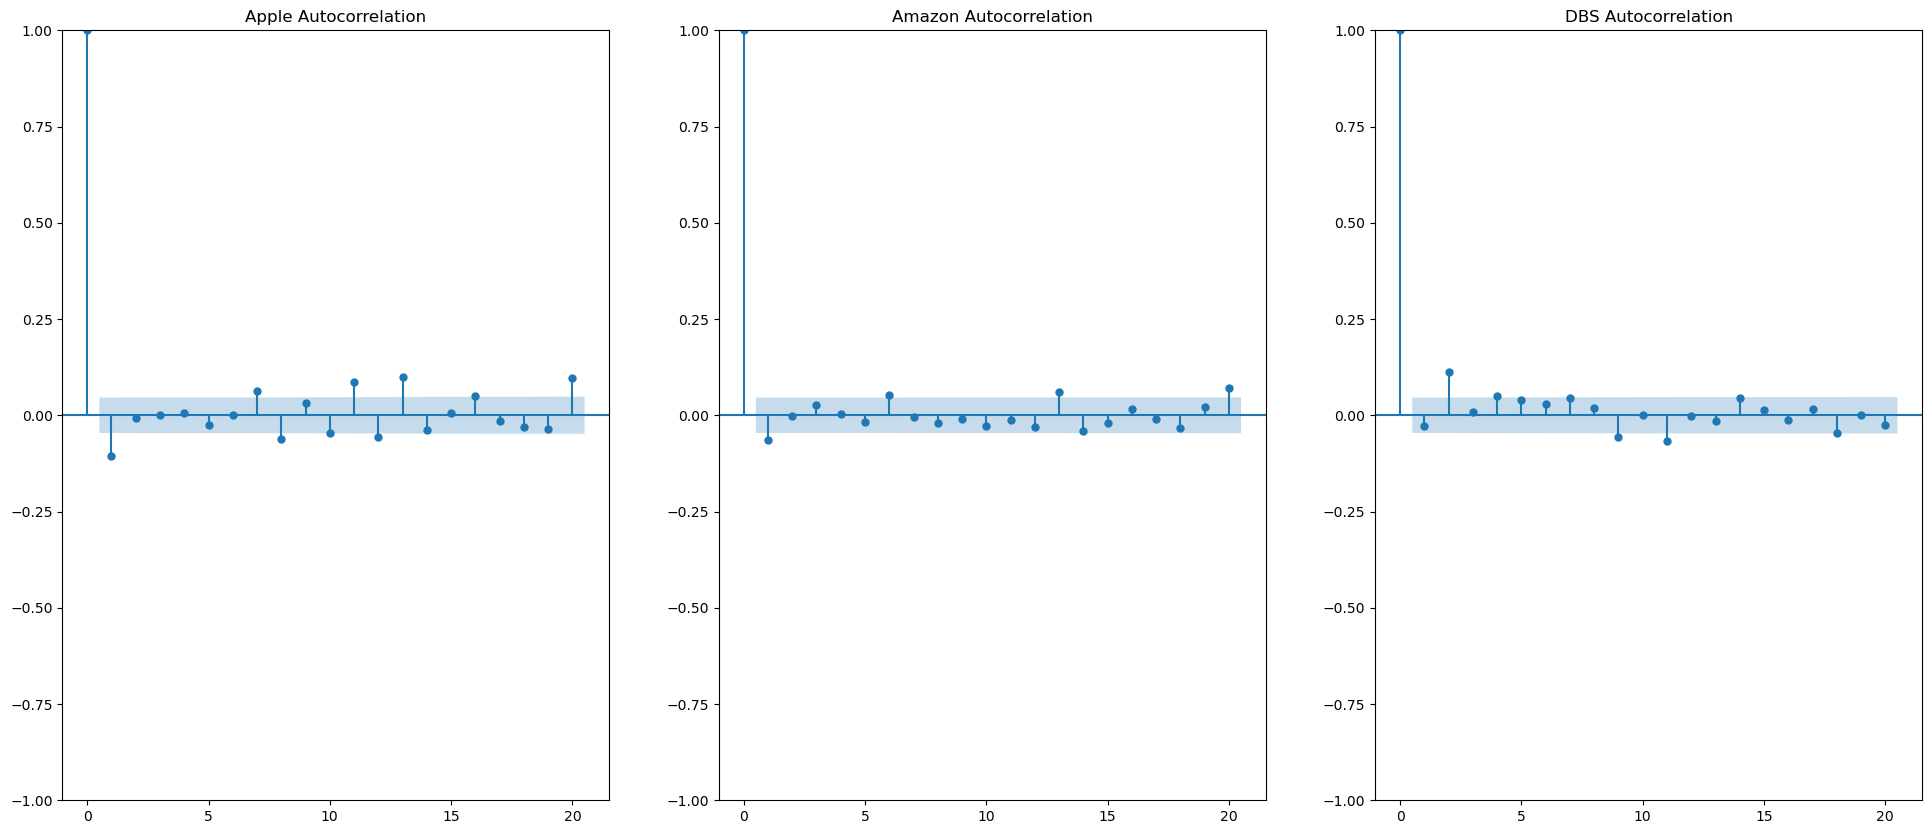

In [211]:
# Autocorrelation 
fig, (ax1, ax2 , ax3) = plt.subplots(1,3, figsize = (24,10))

plot_acf(appleADF, ax=ax1, lags=20)
plot_acf(amazonADF, ax=ax2, lags=20)
plot_acf(dbsADF, ax=ax3, lags=20)
    
ax1.set_title("Apple Autocorrelation")
ax2.set_title("Amazon Autocorrelation")
ax3.set_title("DBS Autocorrelation")


### Holt-Winters Exponential Smoothing Model
<hr>

### Train Test Split

In [205]:
df1 = exog.copy()

In [206]:
traindata= df1.iloc[:(len(df1)-60)]
testdata = df1.iloc[len(df1)-60:]

Mean Squared Error of Apple is 0.00021
Mean Squared Error of Amazon is 0.00032
Mean Squared Error of DBS is 0.00004


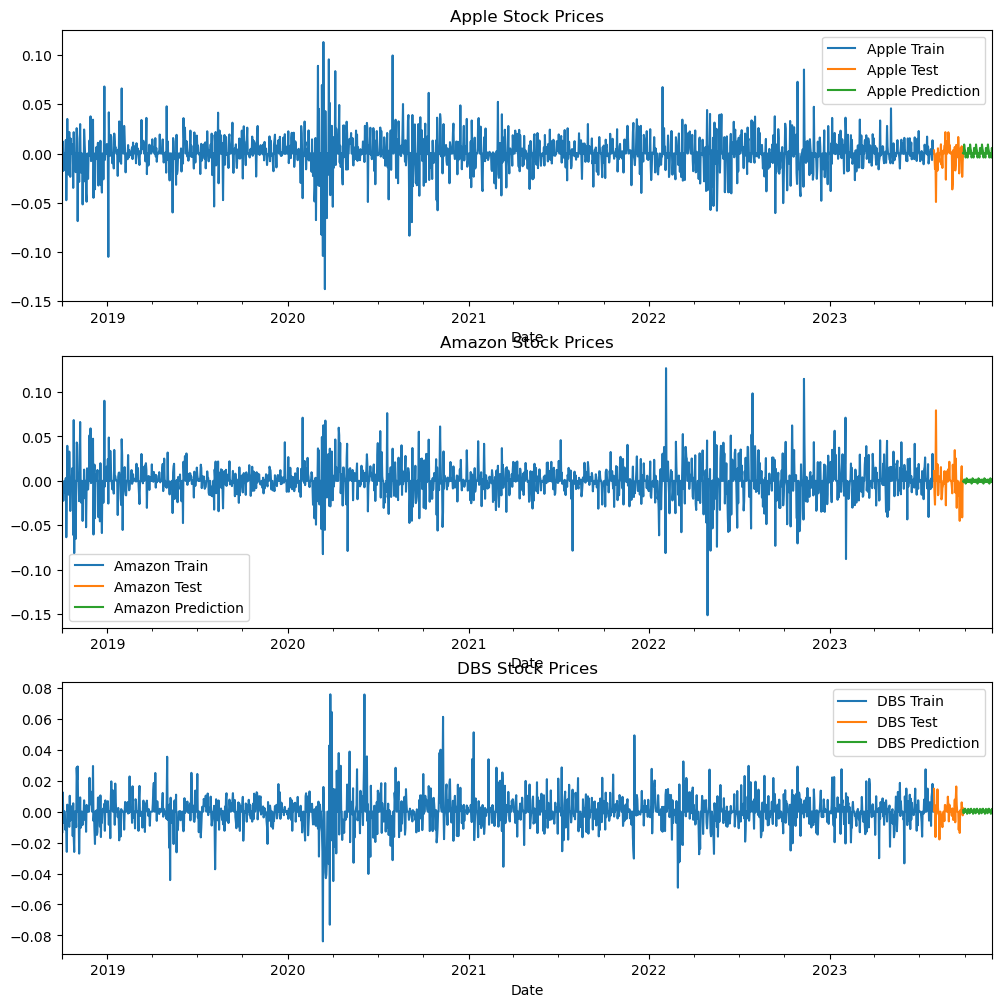

In [207]:
fig, ax = plt.subplots(3, 1, figsize=(12,12))

# loop through between Apple Amazon and DBS
for i, company in enumerate(['Apple', 'Amazon', 'DBS']):
    model = HWES(
        traindata[company],
        seasonal_periods=12,
        trend='add',
        seasonal='add'
    ).fit()
    # predict for exactly 60 days
    pred1 = model.predict(start="2023-09-28", end="2023-11-26")
    
    # plot for from 2019
    traindata[company].iloc[-9000:].plot(label=f'{company} Train', ax=ax[i])
    testdata[company].plot(label=f'{company} Test', ax=ax[i])
    pred1.plot(label=f'{company} Prediction', ax=ax[i])
    ax[i].set_title(f'{company} Stock Prices')
    ax[i].legend()
    
    mse_score = mean_squared_error(testdata[company], pred1)
    print(f'Mean Squared Error of {company} is {mse_score:.5f}')

<h2>Model Evaluations</h2>
<hr>

### SARIMAX

In [208]:
avgMSE  = (apple_w_amazon['mse'] + apple_w_dbs['mse'] + apple_w_rest['mse']) /3
print(f"Average MSE for SARIMAX Stock Model for Apple: {avgMSE}")

avgMSE  = (amazon_w_apple['mse'] + amazon_w_dbs['mse'] + amazon_w_rest['mse']) /3
print(f"Average MSE for SARIMAX Stock Model for Amazon: {avgMSE}")

avgMSE  = (dbs_w_apple['mse'] + dbs_w_amazon['mse'] + dbs_w_rest['mse']) /3
print(f"Average MSE for SARIMAX Stock Model for DBS: {avgMSE}")

Average MSE for SARIMAX Stock Model for Apple: 554.9684395865842
Average MSE for SARIMAX Stock Model for Amazon: 118.18587803576463
Average MSE for SARIMAX Stock Model for DBS: 0.4367724644556988


### Holt-Winters Exponential Smoothing Model

In [209]:
for i, company in enumerate(['Apple', 'Amazon', 'DBS']):
    model = HWES(
        traindata[company],
        seasonal_periods=12,
        trend='add',
        seasonal='add'
    ).fit()
    # predict for exactly 60 days
    pred1 = model.predict(start="2023-09-28", end="2023-11-26")
    
    
    mse_score = mean_squared_error(testdata[company], pred1)
    print(f'Mean Squared Error of {company} is {mse_score:.5f}')

Mean Squared Error of Apple is 0.00021
Mean Squared Error of Amazon is 0.00032
Mean Squared Error of DBS is 0.00004


<h2>Conclusion</h2>
<hr>

### Holt-Winters Exponential Smoothing Model has a much lower MSE score than the SARIMAX , it is much better for predicting stock prices